# Trabajo Práctico - Aprendizaje Automático I


Alumnos:

- Ferrari, Enzo.

- Rodriguez, Abril.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import metrics
import statsmodels.formula.api as smf

## Carga del dataset
El archivo *weather-AUS.csv* consiste en un dataset de registros metereológicos de Australia.

El objetivo del trabajo es la predicción de las variables **RainTomorrow** y **RainFallTomorrow**. Además, se analizará solo sobre las ciudades Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport.


In [ ]:
data = pd.read_csv("weatherAUS.csv")

FileNotFoundError: ignored

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Aprendizaje Automatico I/TP/weatherAUS.csv')

### Filtramos ciudades

Como sólo trabajaremos con 5 ciudades de todo el dataset, las filtraremos.

In [ ]:
data = data[data['Location'].isin(['Sydney','SydneyAirport','Canberra','Melbourne','MelbourneAirport'])]
data

## Exploración del dataset

Con el método 'info' veremos las columnas, la cantidad de registros no-nulos y el tipo de dato que contiene cada una.

In [ ]:
data.info()

El dataset ya filtrado cuenta con 25 columnas y 15986 registros. Sin embargo, se observa que la gran mayoría de las columnas posee valores nulos.

Por otro lado, gran parte de ellas contienen datos tipo float, mientras que algunas pocas son de tipo object.

In [ ]:
print("El dataset contiene ", len(data.columns), " columnas en total.")

In [ ]:
# Separar variables numéricas y categóricas
numerical = []
categorical = []
for columna in data.columns:
  if data[columna].dtype in ['float64','int64']:
    numerical.append(columna)
  if data[columna].dtype == 'object':
    categorical.append(columna)

numerical.remove('Unnamed: 0')
categorical.remove('Date') # No nos interesa explorar la fecha
print(numerical)
print(categorical)

Con el método 'describe', obtendremos un resumen estadístico de cada variable. Esto nos será de interés para ver, en rasgos generales, cómo se distribuye cada una de ellas, así como también los valores mínimos y máximos con el fin de evidenciar valores atípicos a simple vista.

In [ ]:
data_describe = data.describe()
data_describe

En la gran mayoría de las variables la media es aproximadamente igual que la mediana, esto quiere decir que sus distribuciones tienden a ser simétricas.

Se puede concluir que los valores que están presentes en el dataset son certeros, no parece haber valores atípicos en una vista global.

Sin embargo, se cuentan con una gran cantidad de datos faltates, en todas las columnas. Debemos decidir qué hacer con estos datos.

# Datos faltantes
Antes que nada, observemos que para las 4 variables a explicar hay la misma cantidad de valores faltantes (787). Como no tiene sentido rellenar valores para esas 4 variables, vamos a dropearlas. Además, sus faltantes representa menos del 10% del total de los datos.

In [ ]:
data.isnull().sum()

In [ ]:
data.dropna(subset=['Rainfall', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'], inplace=True)


In [ ]:
print(f'Cantidad de registros: {data.shape[0]}')
print(f'Registros con todos los datos presentes: {data.notnull().all(axis=1).sum()}')

print('Cantidad de registros faltantes para cada variable')
data.isna().sum()

Notamos que ninguna columna pasa de un 20% de valores faltantes. Es factible entonces llenar los valores faltantes en todas las columnas.

A continuación, vemos graficados los datos faltantes según localidad

In [ ]:
plt.figure(figsize=(20,60))
x_size = 10
y_size = 5
plt.subplot(x_size,y_size,1)
for n_col, column in enumerate(data.columns):
  plt.subplot(x_size, y_size, n_col + 1)
  data_missing = data.groupby('Location')[column].apply(lambda x: x.isna().sum() / x.size)
  sns.barplot(x=data_missing.index, y=data_missing.values)
  plt.ylabel('Count')
  plt.title(f'{column} missing values')
plt.show()

## Valores faltantes para variables numéricas
Para llenar los valores faltantes de cada variable, consideramos como una opción completar con la media de cada localidad ya que la mayoría de las distribuciones son simétricas.

Sin embargo, notamos que los valores faltantes de cada columna se encuentran distribuidos la mayoría sobre una ciudad. Esto dificulta nuestro método de rellenar valores faltantes ya que una ciudad puede tener una gran cantidad de ellos.

Analizando los valores faltantes de cada columna, vemos que aquellos que tienen una ciudad con una gran proporción de valores faltantes son Evaporation, Sunshine, Cloud9am y Cloud3pm. Podemos considerar tomar las medias globales, pero para esto deberiamos ver que la varianza no sea muy alta.

Podemos ver en el segundo gráfico que no hay una varianza alta, por lo que podemos completar con la media global para estas variables

In [ ]:
problematic_numerical = ['Evaporation','Sunshine', 'Cloud9am', 'Cloud3pm']

# Ver promedios según localidad
plt.figure(figsize=(20,60))
x_size = 10
y_size = 5
plt.subplot(x_size,y_size,1)
for n_col, column in enumerate(problematic_numerical):
  plt.subplot(x_size, y_size, n_col + 1)
  data_missing = data.groupby('Location')[column].mean()
  sns.barplot(x=data_missing.index, y=data_missing.values)
  plt.ylabel('Count')
  plt.title(f'Media de {column}')
plt.show()

In [ ]:
# Completamos missing values
non_problematic_numerical = list(set(numerical) - set(problematic_numerical))
for column in non_problematic_numerical:
  data[column] = data.groupby('Location')[column].transform(lambda x: x.fillna(x.mean()))

for column in problematic_numerical:
  data[column] = data[column].fillna(data[column].mean())


## Valores faltantes para variables categóricas
De manera similar a lo que hicimos para variables numéricas, decidimos completar las variables categóricas con la moda de su respectiva localidad

In [ ]:
# Reemplazar missing values de categóricas

categorical_explicative = list(set(categorical) - set(['Location', 'RainToday', 'RainTomorrow']))

for column in categorical_explicative:
    data[column] = data.groupby('Location')[column].apply(lambda x: x.fillna(x.mode().iloc[0])) # iloc dado que pueden dar varias modas

# Tratamiento de datos
Las variables que tenemos presentes tienen distinta naturaleza: algunas son numéricas, otras categóricas, algunas tienen una mayor importancia que las otras y algunas tienen una mayor cantidad de valores faltantes que otras.

## Análisis
Para conocer la naturaleza de cada variable, debemos realizar un análisis exhaustivo sobre cada una de ellas.

A continuación, un histograma para cada variable númerica, y luego un boxplot.

Text(0.5, 1.0, 'Histogramas variables numéricas')

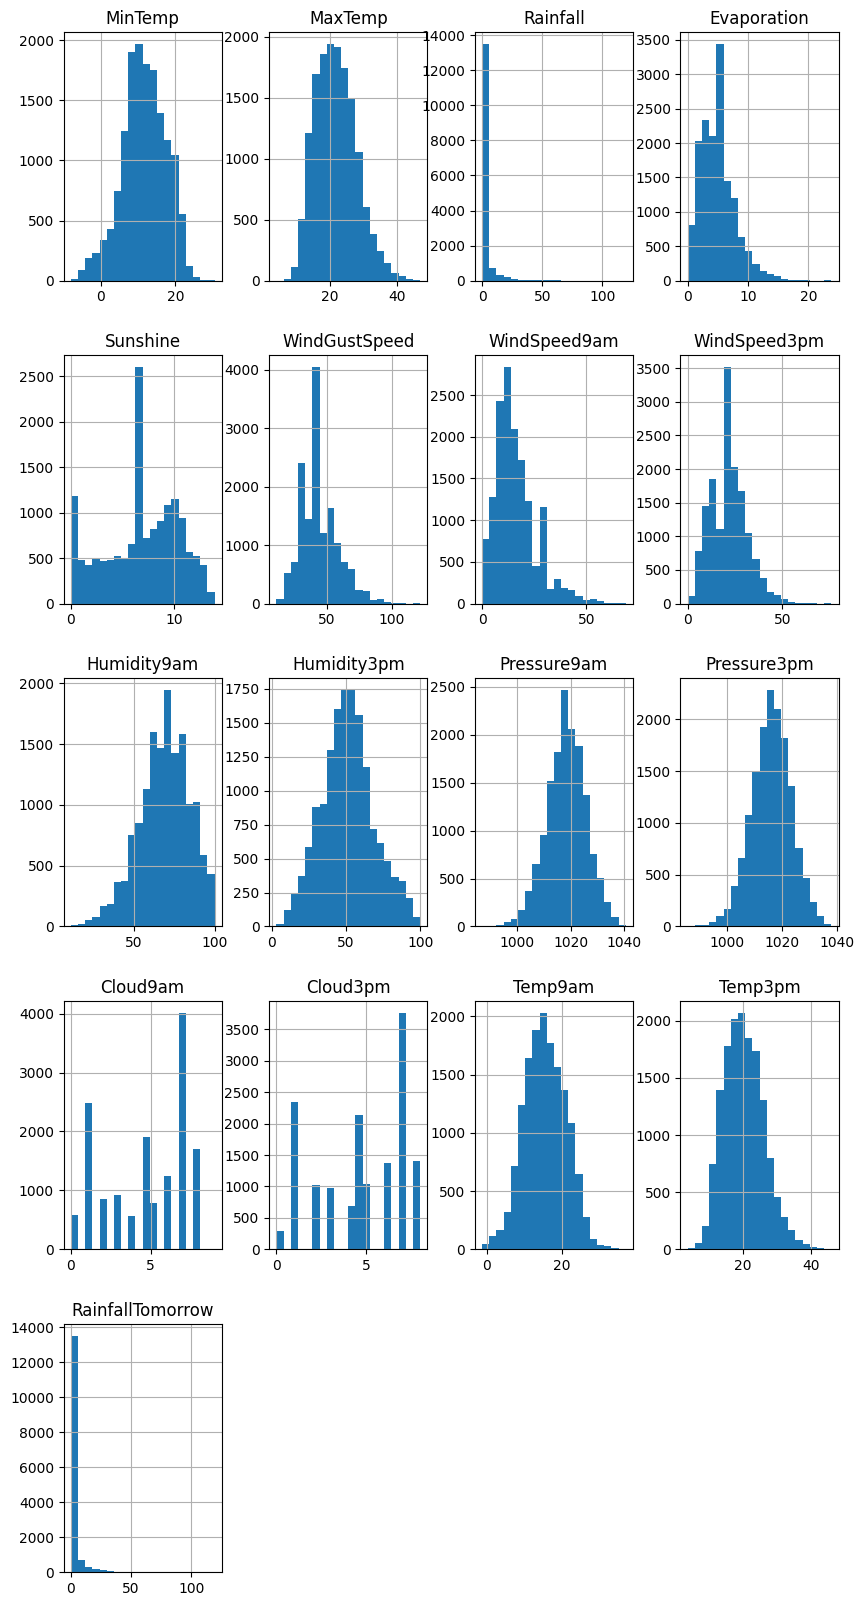

In [ ]:
data[numerical].hist(bins=20, figsize=(10,20))
plt.title('Histogramas variables numéricas')

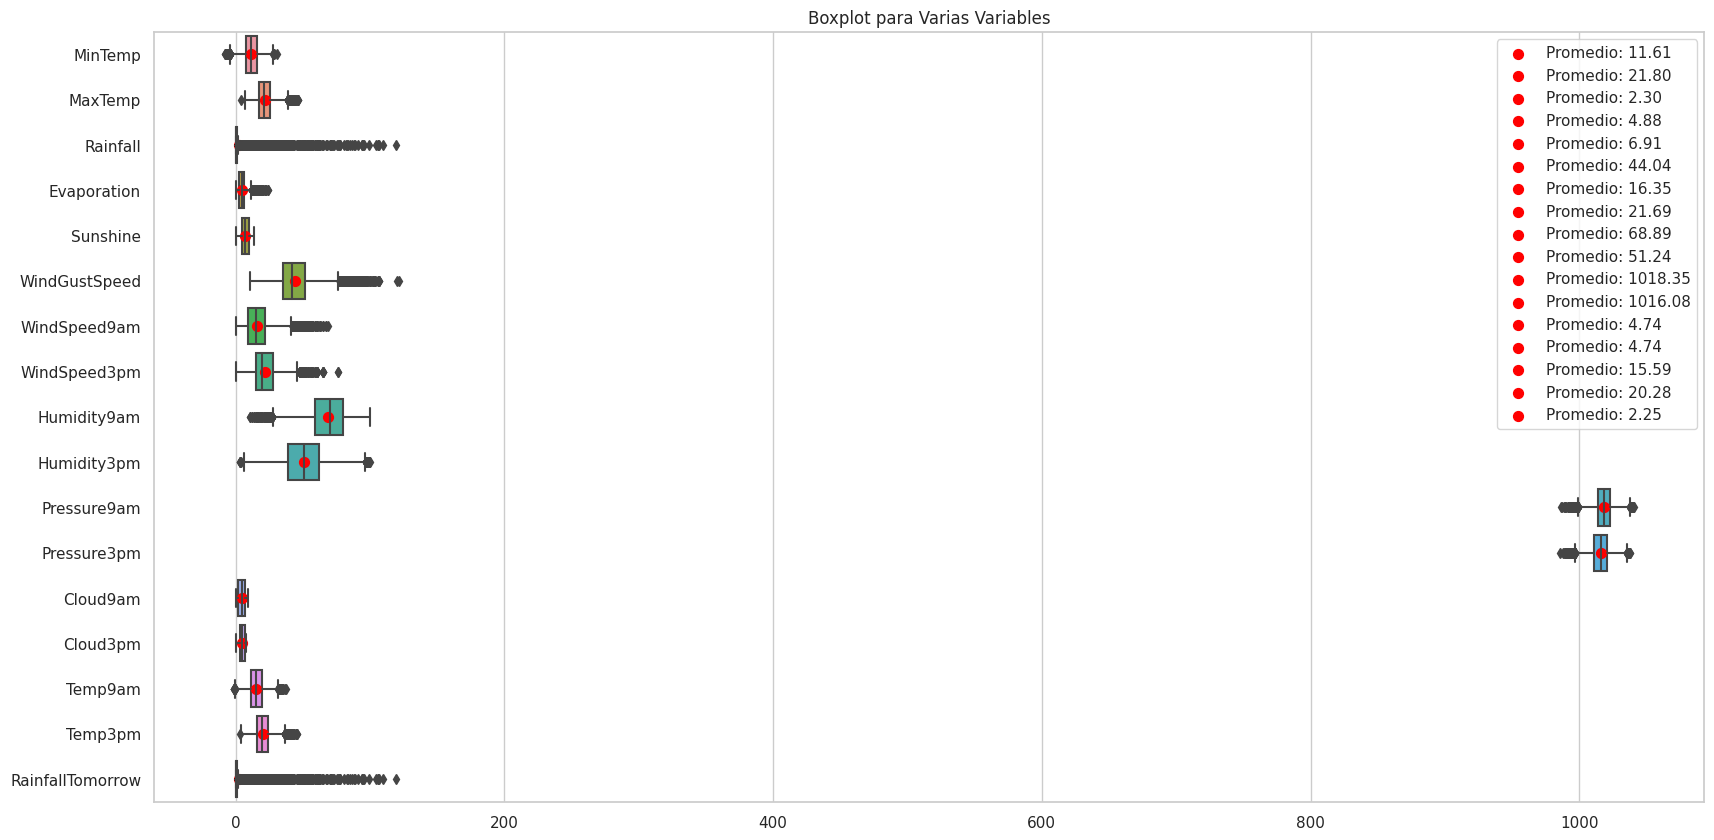

In [ ]:
df_numericas = data[numerical]

means = df_numericas.mean()

sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))  # Tamaño del gráfico
ax = sns.boxplot(data=df_numericas, orient="h")

for i, mean in enumerate(means):
    ax.scatter(mean, i, color='red', marker='o', s=50, label=f'Promedio: {mean:.2f}')
plt.yticks(range(len(df_numericas.columns)), df_numericas.columns)
plt.title("Boxplot para Varias Variables")
plt.legend(loc='upper right')

plt.show() # Muestra el gráfico

Efectivamente, se observa que la mayoría de las variables poseen distribuciones simétricas, es decir, que tienden a ser normales. Sin embargo, hay dos variables en donde esto no se cumple: Rainfall y RainfallTomorrow. Sus distribuciones son asimétricas hacia la derecha ya que la mayoría de los días no llueve. A causa de esto, gran parte de los días donde ha llovido se tomaron como atípicos (como se vio en los boxplot)

Luego, graficaremos las variables categóricas para visualizar cómo se comportan.

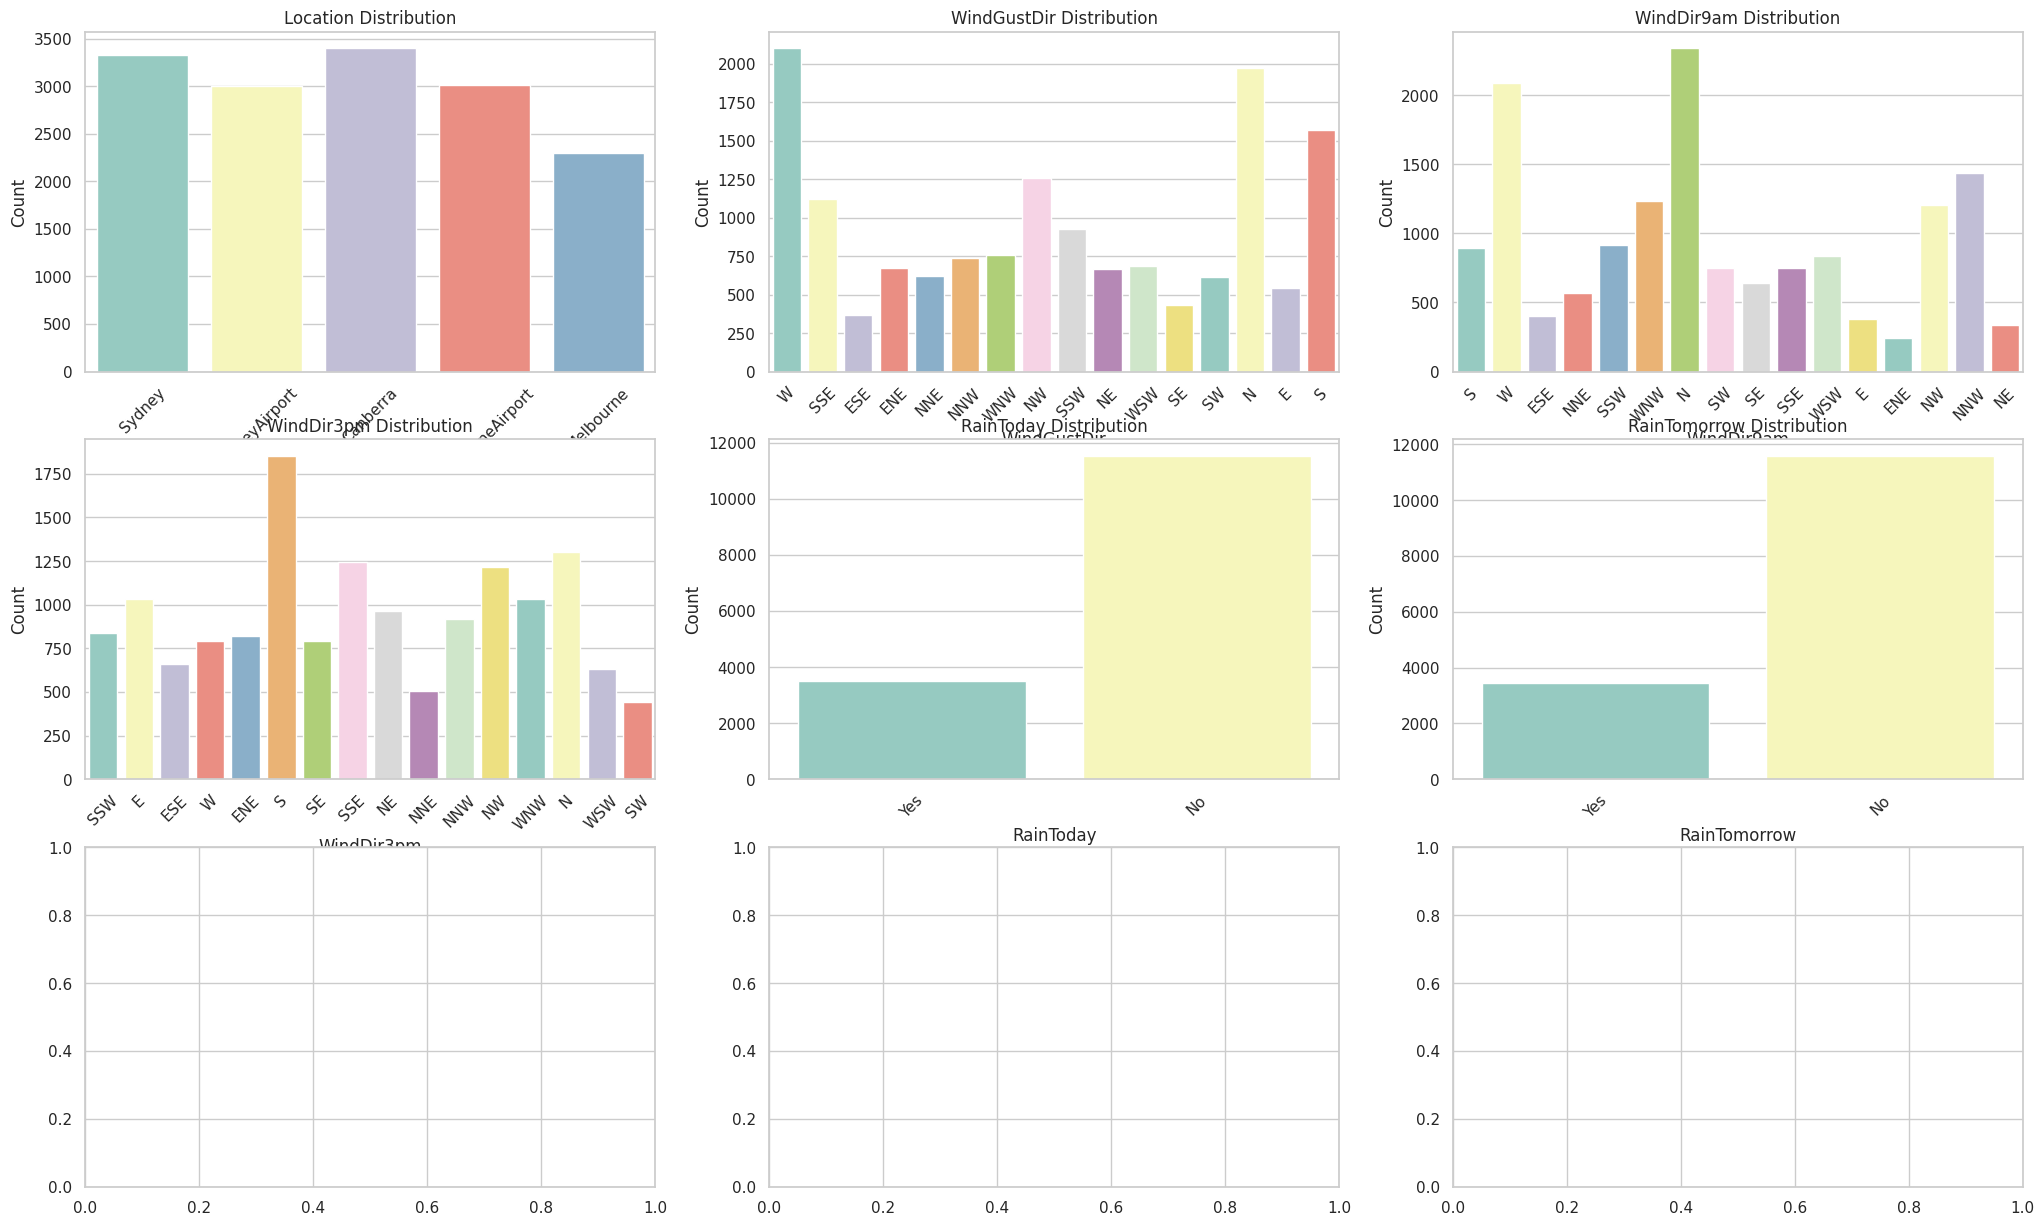

In [ ]:
# Gráficos de frecuencias de variables categóricas

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(25, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through categorical variables and create countplots in subplots
for i, var in enumerate(categorical):
    sns.countplot(data=data, x=var, palette="Set3", ax=axes[i])
    axes[i].set_title(f'{var} Distribution')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability



### Análisis exploratorio: Variable objetivo

Veamos como se comporta cada variable respecto con la variable objetivo

Primero, veamos como está distribuida nuestra variable objetivo

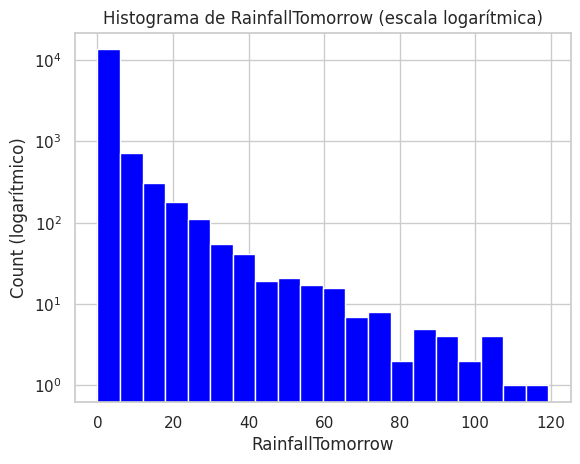

Text(0.5, 1.0, 'Bar plot de días de lluvia')

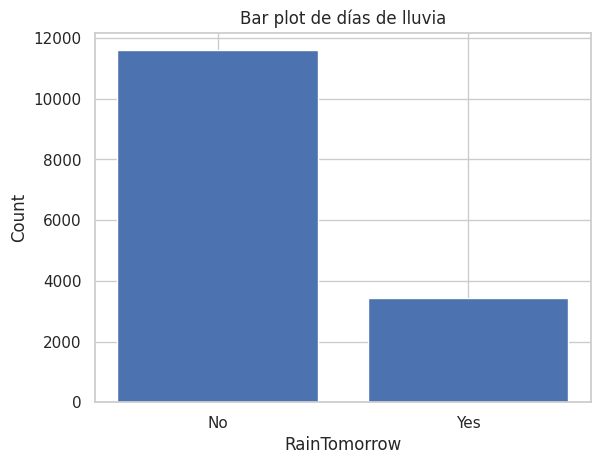

In [ ]:
# Transformación logarítmica
# Calculamos los datos del histograma
counts, bins, _ = plt.hist(data['RainfallTomorrow'], bins=20, alpha=1, color='blue')
plt.yscale('log')
plt.xlabel('RainfallTomorrow')
plt.ylabel('Count (logarítmico)')
plt.title('Histograma de RainfallTomorrow (escala logarítmica)')
plt.show()

# RainTomorrow
RainTomorrow_counts = data['RainTomorrow'].value_counts()
RainTomorrow_counts
plt.bar(RainTomorrow_counts.index, RainTomorrow_counts.values)
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.title('Bar plot de días de lluvia')

Se puede observar que hay una mayor cantidad de datos donde no llueve comparado con los días que llueve. Esto puede hacer que el modelo sea mejor para predecir dias en los que no llueva.

Por esta razón, los datos no se encuentran balanceados y este hecho se debe tener en cuenta en caso de realizar clasificación o dependiendo los objetivos del problema.

## Análisis exploratorio: Scatter plot
Veamos ahora como se relaciona cada variable respecto a nuestra variable objetivo. Para esto, usamos scatter plots.

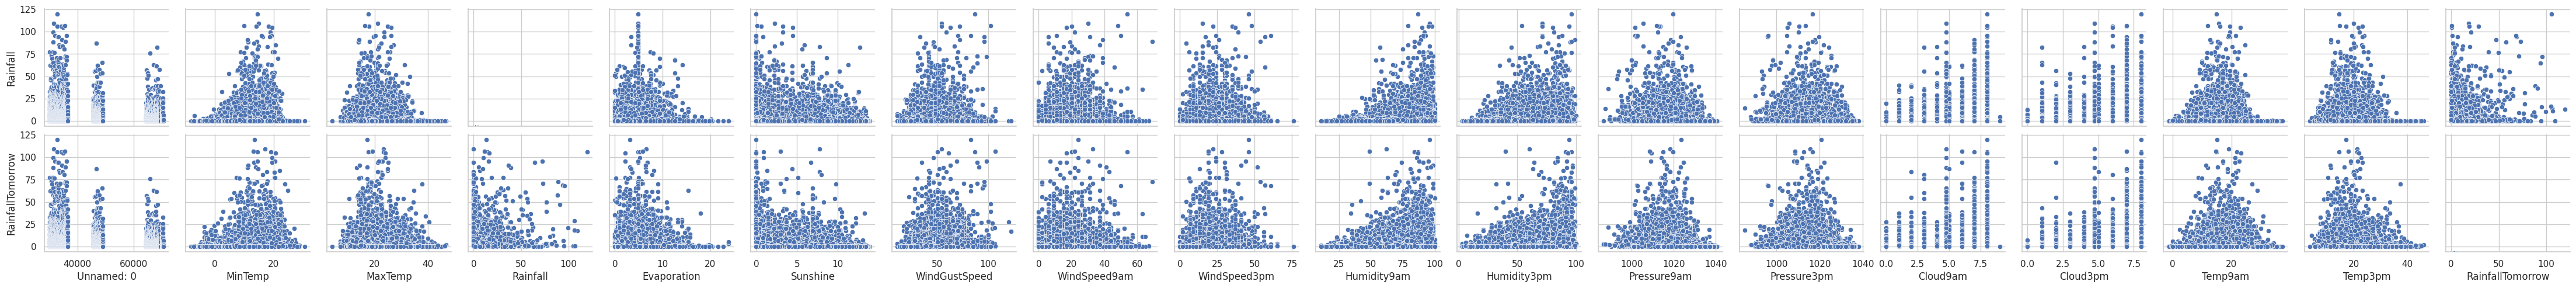

In [ ]:
# pairplot crea scatterplots de todas las variables del dataset
sns.pairplot(data, y_vars=['Rainfall', 'RainfallTomorrow'])


## Análisis de correlación
Veamos ahora si existe correlación entre las variables explicativas, así podemos evitar el problema de la multicolinearidad.

Haremos un mapa de calor entre variables y analizaremos sus coeficientes de correlación.

<ipython-input-24-05e6fc59747d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr = data.drop(['Date', 'Location', 'Unnamed: 0'], axis=1).corr()


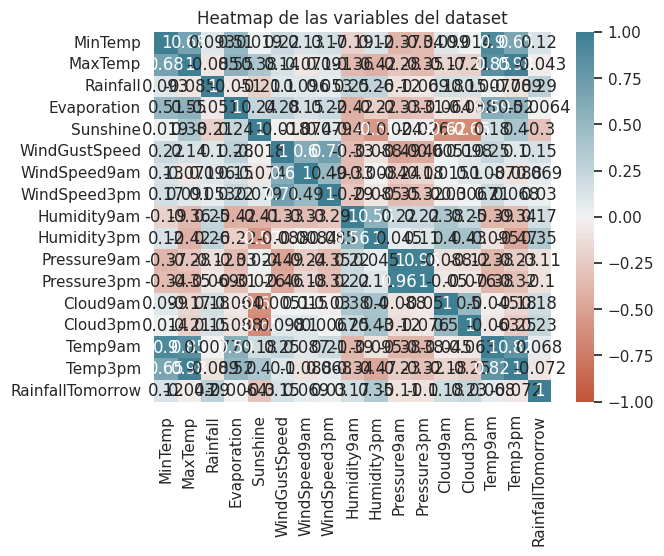

In [ ]:
# Buscar correlación entre las variables numéricas:
matrix_corr = data.drop(['Date', 'Location', 'Unnamed: 0'], axis=1).corr()
ax = sns.heatmap(
    matrix_corr,
    vmin=-1,vmax=1,center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    annot=True
)
plt.title('Heatmap de las variables del dataset')
plt.show()


Como contamos con muchas variables, se hace complicado visualizarlas correctamente. Veamos aquellos pares que tengan mayor correlación.

In [ ]:
# Creamos la matriz
matrix_corr = data.drop(['Date','Location','Unnamed: 0'], axis=1).corr(method='spearman')

upper_matrix_corr = matrix_corr.where( # Argumento: matriz de booleanos
    np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool) # Crea una matriz de booleanos, creando una matriz triangular superior
)
# Con estas matrices triangulares superiores
top_pos_corr = upper_matrix_corr.unstack().dropna().sort_values(ascending=False).head(25)
top_neg_corr = upper_matrix_corr.unstack().dropna().sort_values(ascending=True).head(20)

print(top_pos_corr)
print(top_neg_corr)

Temp3pm           MaxTemp          0.978243
Pressure3pm       Pressure9am      0.956869
Temp9am           MinTemp          0.907097
                  MaxTemp          0.866553
Temp3pm           Temp9am          0.837467
MaxTemp           MinTemp          0.713532
WindSpeed3pm      WindGustSpeed    0.698901
Temp3pm           MinTemp          0.687997
Temp9am           Evaporation      0.600447
Evaporation       MaxTemp          0.573714
Temp3pm           Evaporation      0.544057
Humidity3pm       Humidity9am      0.540501
WindSpeed9am      WindGustSpeed    0.538095
Evaporation       MinTemp          0.524494
Cloud3pm          Cloud9am         0.507037
RainfallTomorrow  Humidity3pm      0.448709
WindSpeed3pm      WindSpeed9am     0.446702
Cloud3pm          Humidity3pm      0.444750
Cloud9am          Humidity3pm      0.420676
RainfallTomorrow  Cloud3pm         0.417495
Temp3pm           Sunshine         0.414006
Cloud9am          Humidity9am      0.400371
Sunshine          MaxTemp       

<ipython-input-25-b4fc176aae75>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr = data.drop(['Date','Location','Unnamed: 0'], axis=1).corr(method='spearman')
<ipython-input-25-b4fc176aae75>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool) # Crea una matriz de booleanos, creando una matriz triangular superior


## Selección de variables
La correlación entre las variables explicativas debe ser tenida en cuenta en el momento de aplicar el modelo. A pesar de que la correlación no afecta directamente al modelo, si incluímos variables que están fuertemente relacionadas, agregar ambas puede ser redundante, o incluso puede ser complicado interpretar los coeficientes dado que la multicolinearidad puede dar malos valores del z-value.

### Criterios

Decidimos tomar el siguiente criterio para tratar los pares de variables respecto a su correlación:
- entre 0.7 y 1: Alta correlación, estos pares deben ser tratados si o si.
- entre 0.3 y 0.7: Correlación moderada, se deben tomar consideraciones respecto a si tratamos o no estas variables.
- entre 0 y 0.3: Correlación baja, ignoramos estos pares.

Sin embargo, hay que esperar que haya correlación entre variables, al ser datos del clima, hay que considerar ser flexibles con este indicador.

### Variables

Por lo visto en las tablas anteriores, notamos que las siguientes variables tienen una correlación considerable:
- MinTemp, MaxTemp, Temp3pm, Temp9am: Todos los pares tomados de estas variables tienen una correlación alta, llegando lo más alto a ser 0.97. MinTemp tiene alta correlación con Temp9am y MaxTemp con Temp3pm, lo que es lógico ya que los extremos de temperatura se suelen dar en esos horarios. Se decide dropear Temp9am y Temp3pm y quedarnos con Min y Max, ya que aportan mayor explicabilidad. Sin embargo, también creamos una nueva columna que es el promedio, luego experimentando con los modelos decidiremos con cuál quedarnos.
- Pressure9am, Pressure3pm: Alta correlación, es razonable tomar el promedio entre estas dos para reducir las variables. Otra opción puede ser quedarnos con Pressure9am e incluir una nueva variable que tome la diferencia de presión, no habrá correlación y guarda la información de las dos variables.
- WindGustSpeed, WindSpeed9am, WindSpeed3pm: WindGustSpeed tiene una fuerte correlación con WindSpeed3pm, podríamos considerar dropear WindGustSpeed, y nos quedaríamos con WindSpeed3pm y WindSpeed9am.
- Sunshine: Tiene correlación negativa considerable con múltiples variables, puede generar muchos problemas incluirla. Podríamos dropearla esperando que la información de las nubes y la humedad. Sin embargo, tiene correlación con RainFallTomorrow ¿Qué hacemos?

### ¿Cómo podemos incluir la fecha?
A pesar de que no es incluir a la fecha como variable en el modelo, podemos tratar de convertirlo en algo más manejable. Una opción es tomar la temporada y otra es tomar el mes. Optamos por tomar el mes.

### Alternativa para la dirección del viento
Hay 16 tipos distintos de dirección. Podemos usar una transformación trigonométrica para representar la dirección, y así pasar de una variable categórica con 16 categorías a dos numéricas.

De esta manera perdemos interpretabilidad (¿Cómo entendemos la evaluación del coseno y seno en el modelo?) pero compactamos las variables y contemplamos la cercanía y naturaleza de las direcciones (en una codificación one-hot todas las direcciones son perpendiculares).

¡Incluso podemos hacer lo mismo para la fecha!

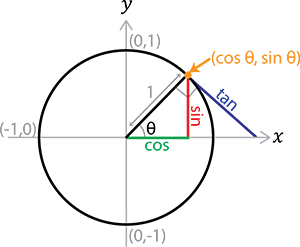

A continuación, agregaremos una nueva variable al dataset: "Month". Ésta será necesaria a la hora de hacer regresión y mucho más manejable que "Date".

In [ ]:
# Convertir la fecha a meses
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.strftime('%b')
data['Month']

30167    Feb
30168    Feb
30169    Feb
30170    Feb
30171    Feb
        ... 
70366    Jun
70367    Jun
70368    Jun
70369    Jun
70370    Jun
Name: Month, Length: 15036, dtype: object

Luego, agregaremos más columnas: otras maneras de representar las direcciones de los vientos y los meses (variables categóricas) con valores de seno y coseno. Este criterio lo tomamos con el fin de analizar qué maneras de representar estos datos son mejores/más eficientes a la hora de realizar regresión lineal.

In [ ]:
from datetime import datetime

# Definir una función que transforme dirección a componentes seno y coseno
# Primero, creemos un diccionario que represente cada dirección con su ángulo en grados
direction_to_angle = {
    'N': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'E': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'S': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'W': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}
# Tomamos como referencia las direcciones en la convención que aparece en Wikipedia https://en.wikipedia.org/wiki/Points_of_the_compass
def dir_to_circle(series_direccion):
  '''
  Transforma a coordenadas polares la dirección.
  Recibe como entrada el Series con las direcciones.
  Devuelve un par ordenado donde la primera componente
  representa el Series con los valores del coseno y
  la segunda los valores del seno
  '''
  # numpy toma valores en radianes, necesitamos convertirlo primero
  direccion_radian = series_direccion.map(direction_to_angle).apply(np.deg2rad)

  # Transformamos a seno y coseno
  sine_series = direccion_radian.apply(np.sin)
  cosine_series = direccion_radian.apply(np.cos)
  return cosine_series, sine_series

dir_to_circle(data['WindGustDir'])
def is_leap_year(date):
  # Chequear si es un datetime es año bisiesto
  is_leap_year = (date.year % 4 == 0) and (date.year % 100 != 0 or date.year % 400 == 0)
  return is_leap_year

def date_to_circle(series_fecha):
  '''
  Transforma a representación coseno-seno la fecha.
  Recibe como entrada el Series con los datetime.
  Devuelve un par ordenado donde la primera componente
  representa el Series de los valores del coseno y
  la segunda los del seno
  '''
  direccion_radian = series_fecha.apply(lambda x: 2 * np.pi * x.dayofyear / (366 if is_leap_year(x) else 355)) # Pasar a radianes la fecha (vuelta completa si es un año entero)

  # Transformamos a seno y coseno
  sine_series = direccion_radian.apply(np.sin)
  cosine_series = direccion_radian.apply(np.cos)
  return cosine_series, sine_series

date_to_circle(data['Date'])

(30167    0.852864
 30168    0.843776
 30169    0.834438
 30170    0.824855
 30171    0.815028
            ...   
 70366   -0.993390
 70367   -0.995266
 70368   -0.996830
 70369   -0.998082
 70370   -0.999021
 Name: Date, Length: 15036, dtype: float64,
 30167    0.522133
 30168    0.536696
 30169    0.551102
 30170    0.565345
 30171    0.579421
            ...   
 70366    0.114791
 70367    0.097191
 70368    0.079562
 70369    0.061907
 70370    0.044233
 Name: Date, Length: 15036, dtype: float64)

In [ ]:
datetime_str = '2006-02-20'
datetime_obj = pd.to_datetime(datetime_str)

dayofyear_sin = np.sin(2 * np.pi * datetime_obj.dayofyear / 365)
dayofyear_cos = np.cos(2 * np.pi * datetime_obj.dayofyear / 365)

print(f'Date: {datetime_obj}')
print(f'DayofYear_sin: {dayofyear_sin}')
print(f'DayofYear_cos: {dayofyear_cos}')


Date: 2006-02-20 00:00:00
DayofYear_sin: 0.7694148268839378
DayofYear_cos: 0.6387494220515272


## Nuevos métodos
En la materia se han visto métodos de regularización, por lo que podemos, luego de tratar los valores faltantes, mantener los outliers para contemplar la aplicación de estos modelos y luego crear otro modelo para tratar los outliers.

In [ ]:
data_no_outliers = data.copy()

# Outliers
Observando el histograma de frecuencia anteriormente, vemos que no hay outliers que hayan sido producto de un bad input, son todos outliers naturales.

En esta sección, trataremos los outliers en el dataframe 'data_no_outliers', mientras que el dataframe anterior 'data' quedará sin tratar. De esta manera, utilizaremos estos dos dataframes para realizar regresión y visualizar qué tanto varían los resultados.

# Cambiar outliers
Decidimos tomar como método para tratar outliers al winsoring. Para esto, colapsamos los outliers sobre el rango intercuartil.

In [ ]:
# Reemplazar outliers
def reemplazar_outliers(series):
  '''Función auxiliar para usar con el método transform en el groupby.
  Toma como entrada un Series y colapsa los outliers al rango intercuartil'''

  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1

  # Definimos los límites intercuartílicos
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR

  # Usamos la librería numpy para reemplazar outliers en el series
  series[series > limite_superior] = limite_superior
  series[series < limite_inferior] = limite_inferior
  return series

<Figure size 800x800 with 0 Axes>

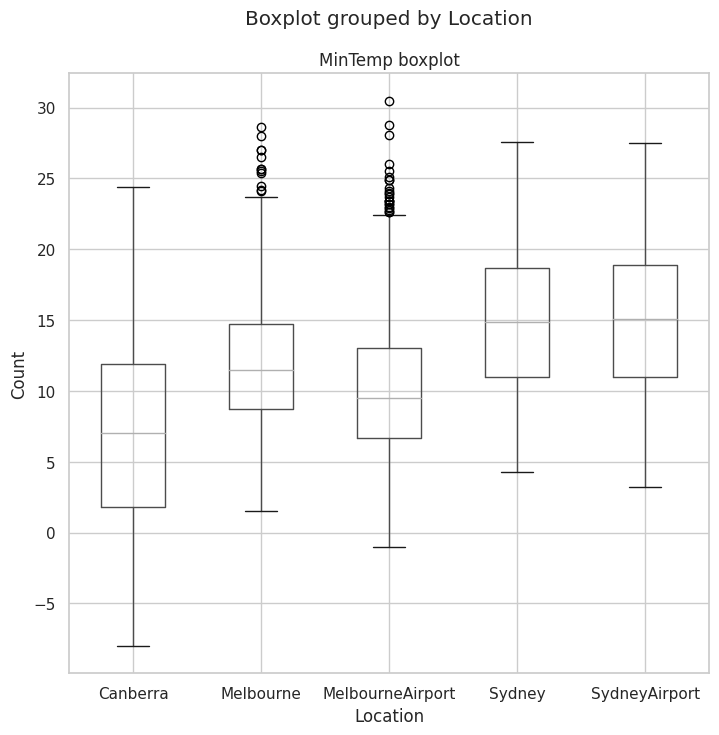

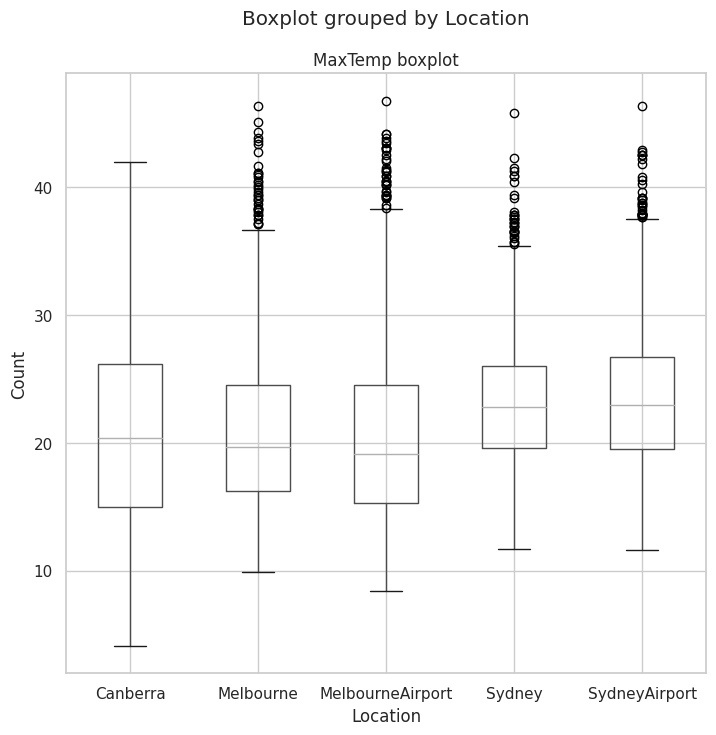

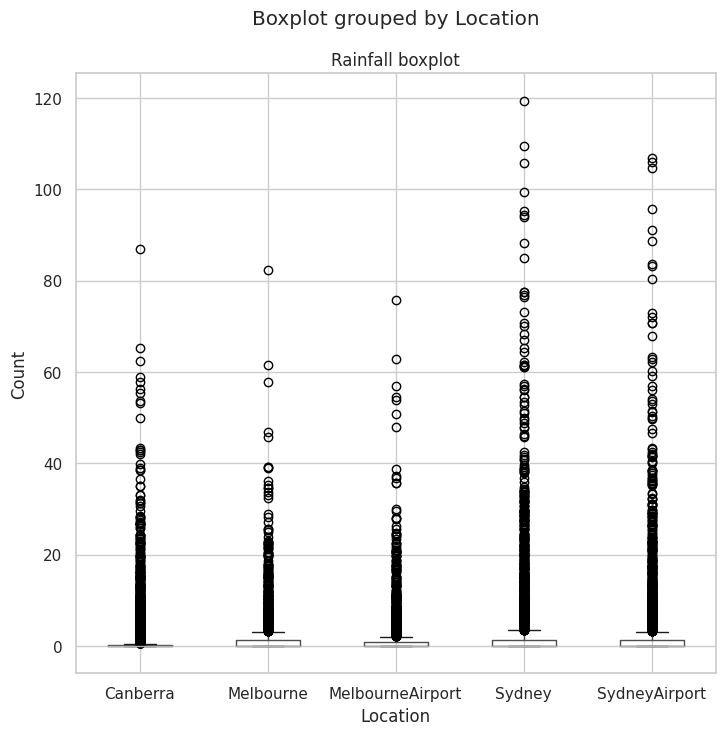

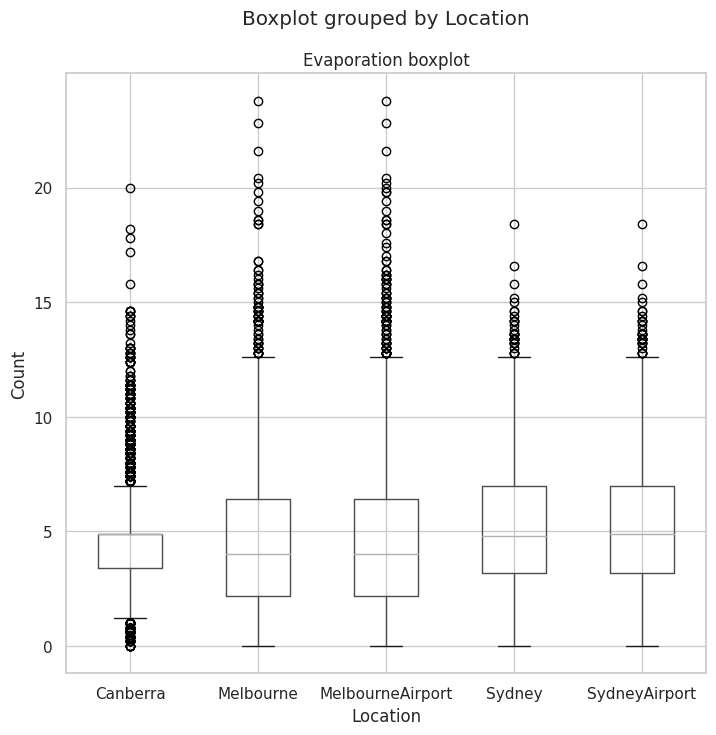

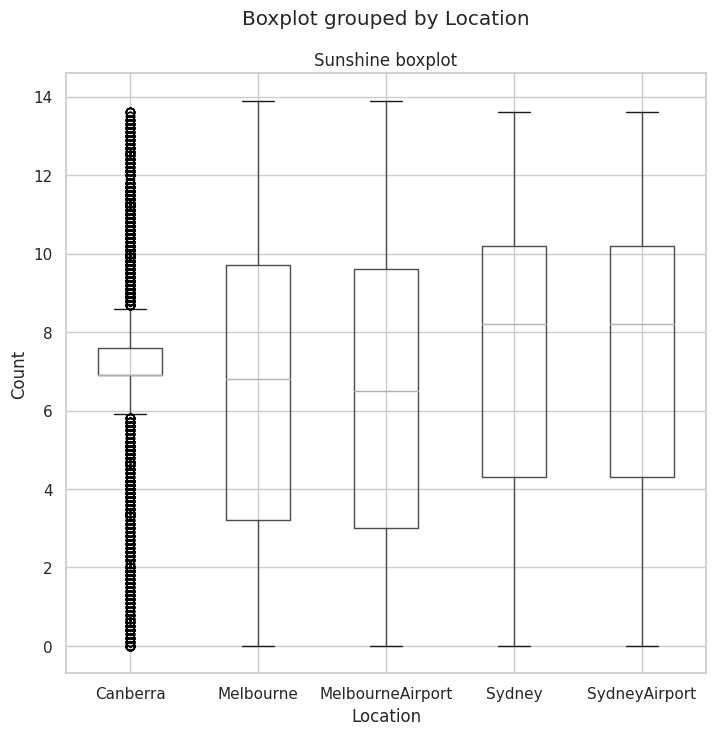

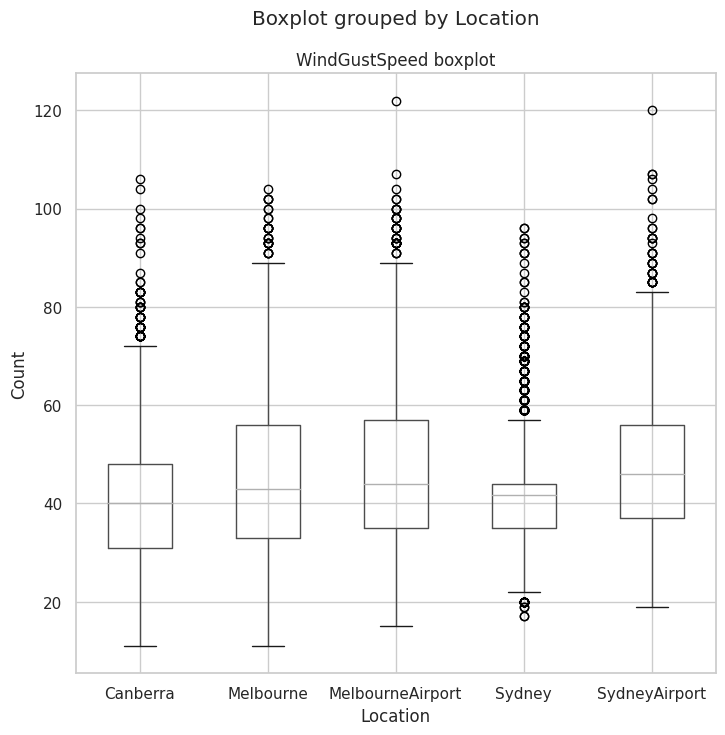

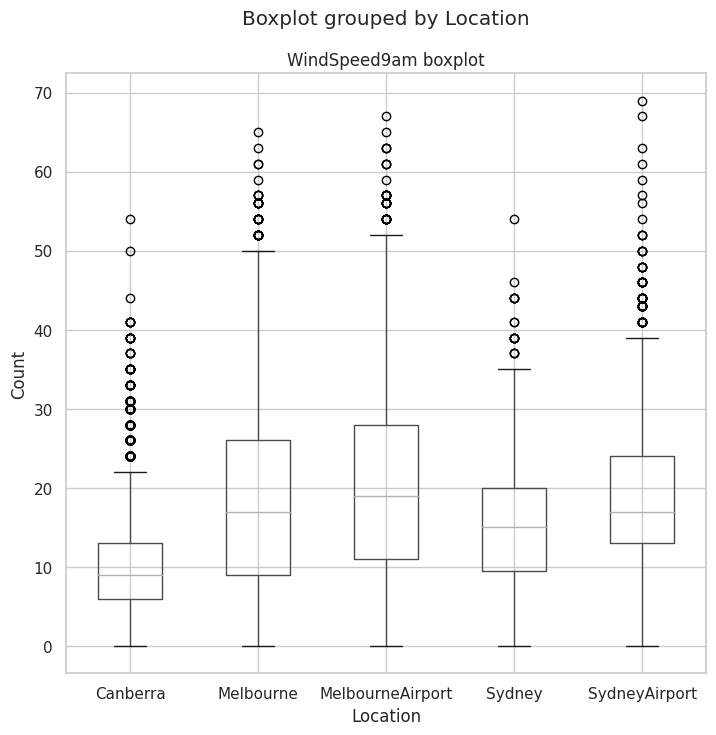

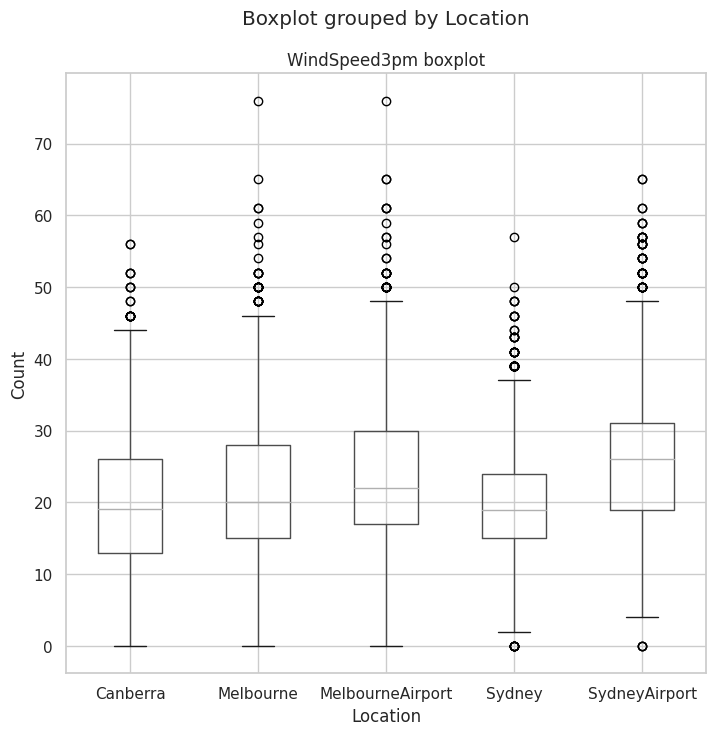

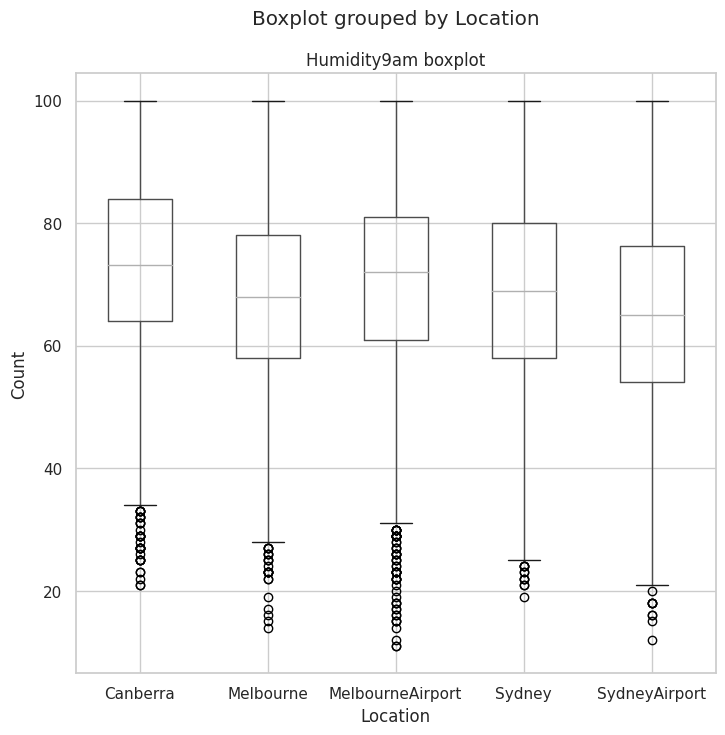

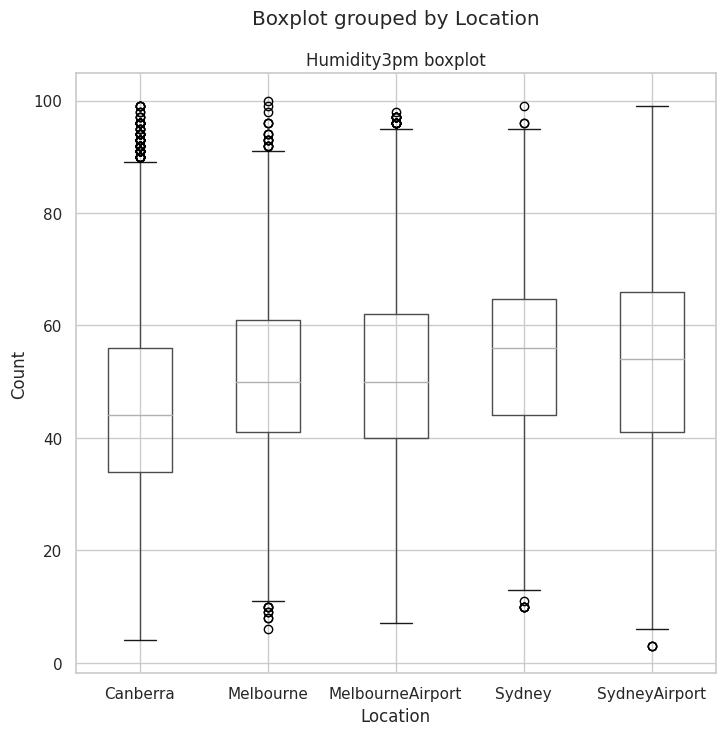

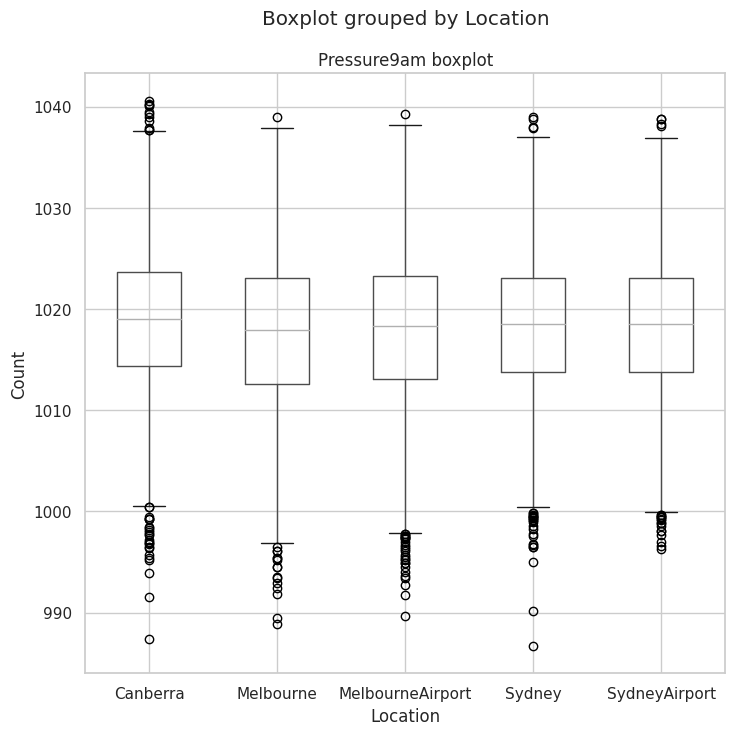

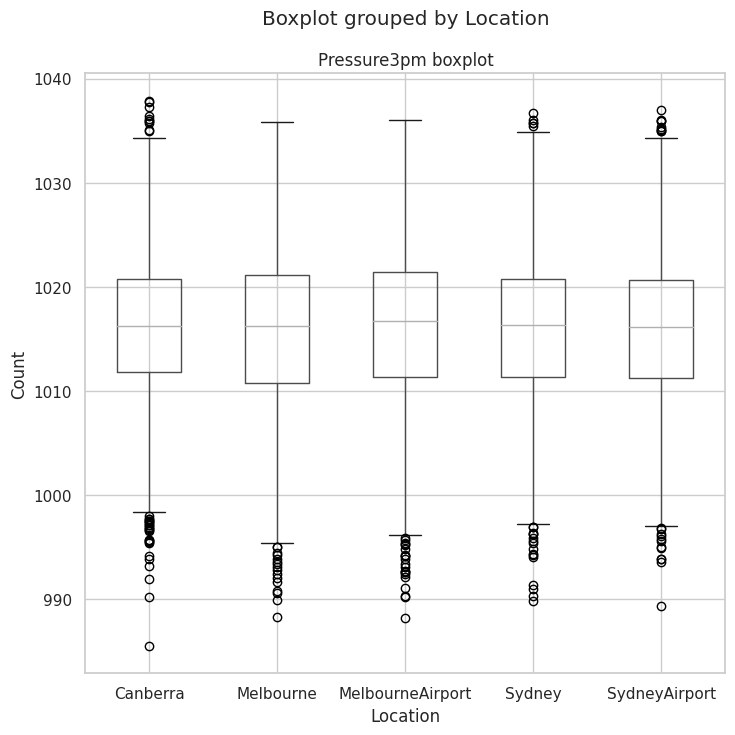

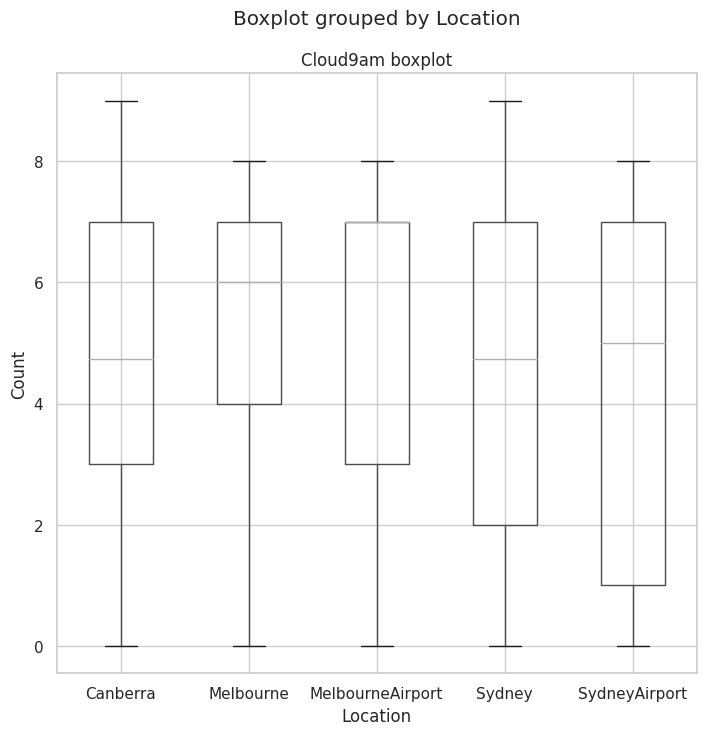

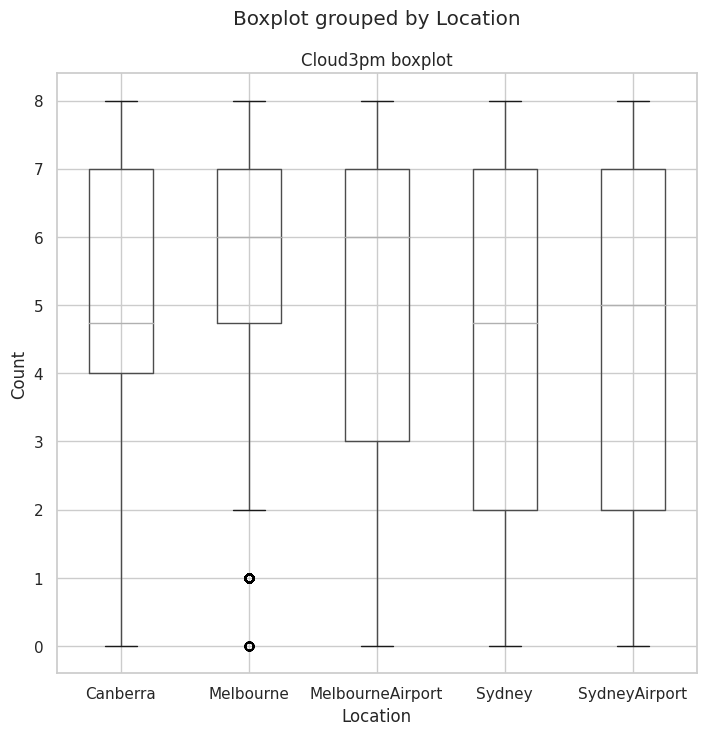

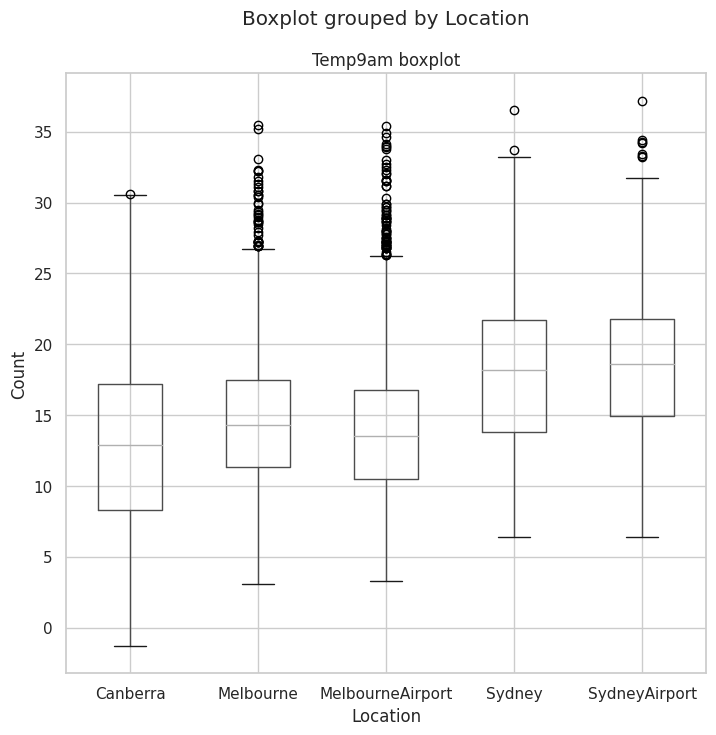

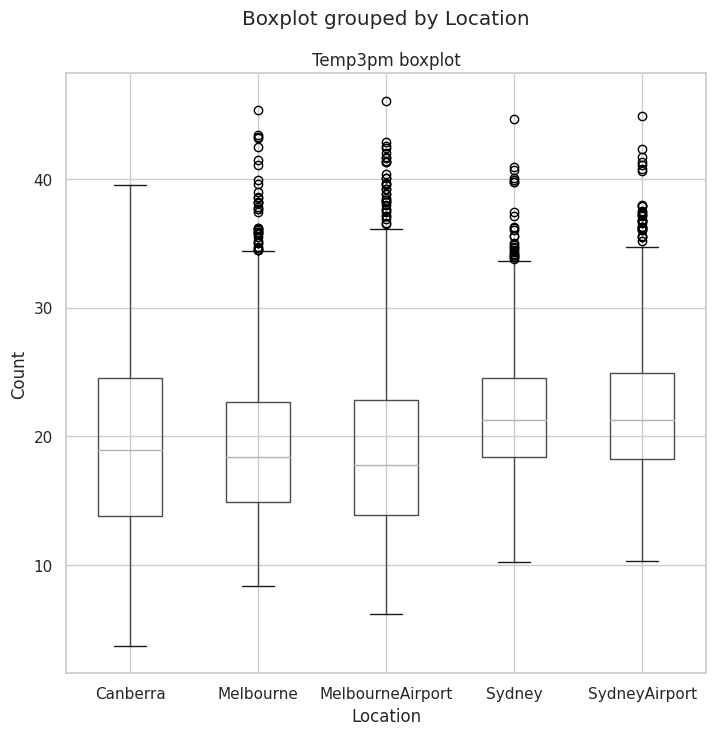

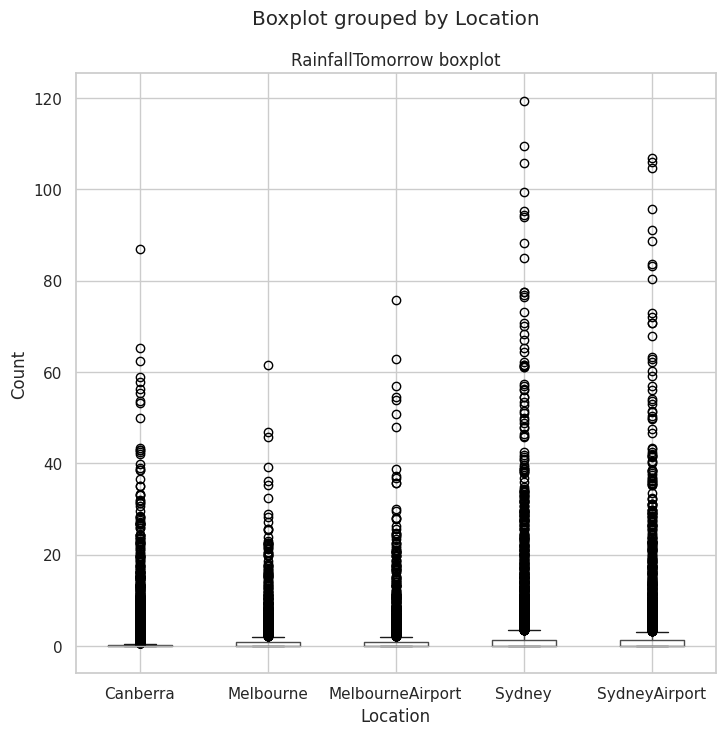

In [ ]:
# Visualizar boxplots según localidad
plt.figure(figsize=(8,8))
x_size = 10
y_size = 5
for n_col, column in enumerate(numerical):
  fig, axes = plt.subplots(figsize=(8,8))
  data.boxplot(column=column, by='Location', ax=axes)
  plt.ylabel('Count')
  plt.title(f'{column} boxplot')
  plt.show()


Cambiamos outliers con la función anteriormente definida, y volvemos a visualizar los boxplot para ver cómo han cambiado.

In [ ]:
# Cambiar outliers
numerical_explicative = list(set(numerical) - set(['Rainfall', 'RainfallTomorrow']))

for column in numerical_explicative:
  data_no_outliers[column] = data.groupby('Location')[column].transform(reemplazar_outliers)

<Figure size 800x800 with 0 Axes>

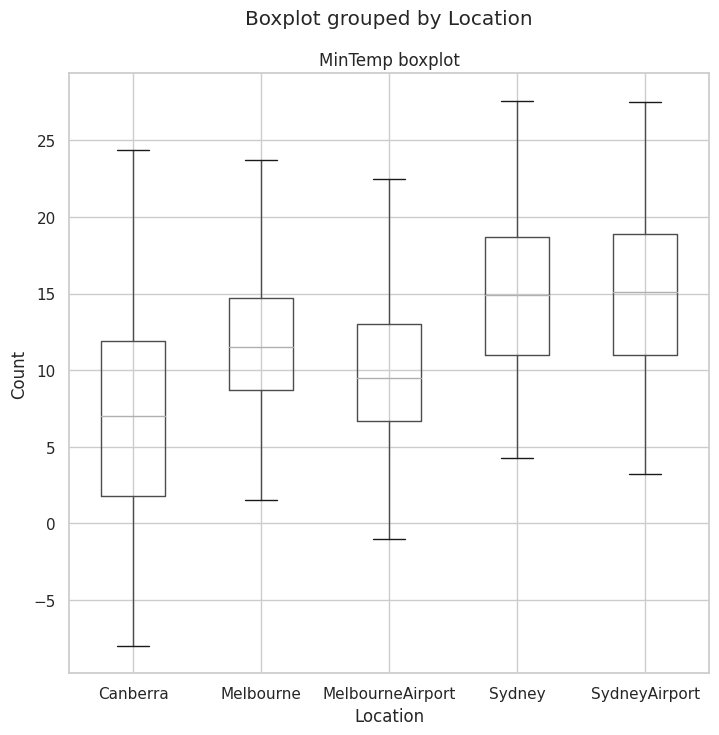

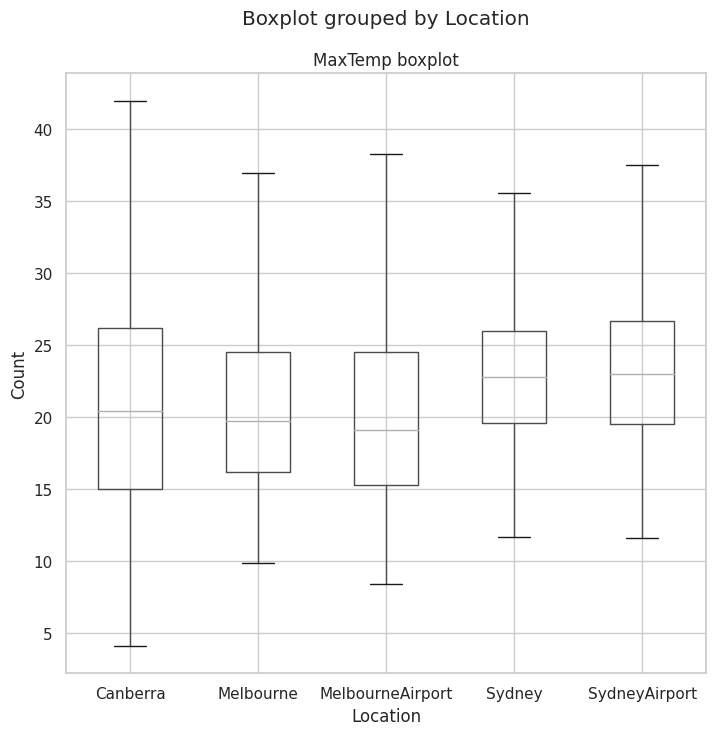

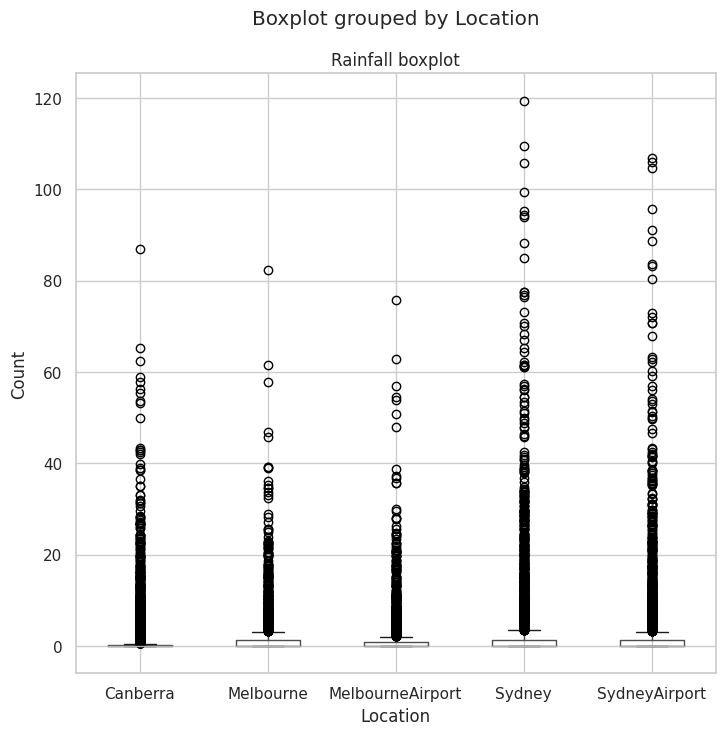

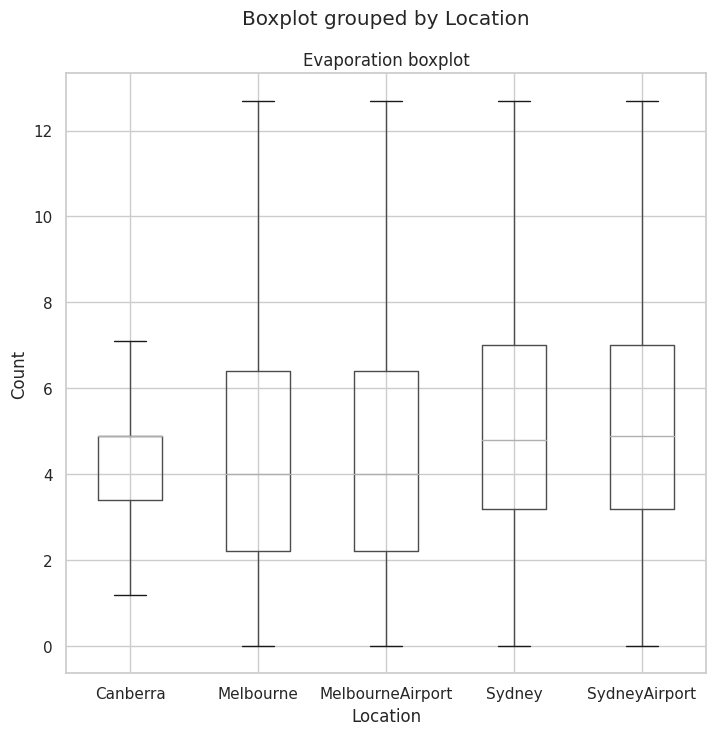

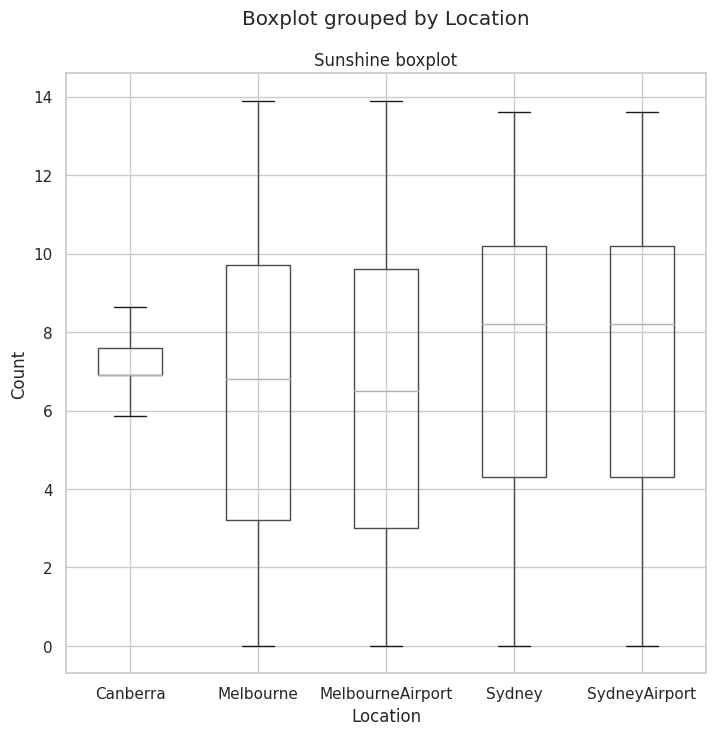

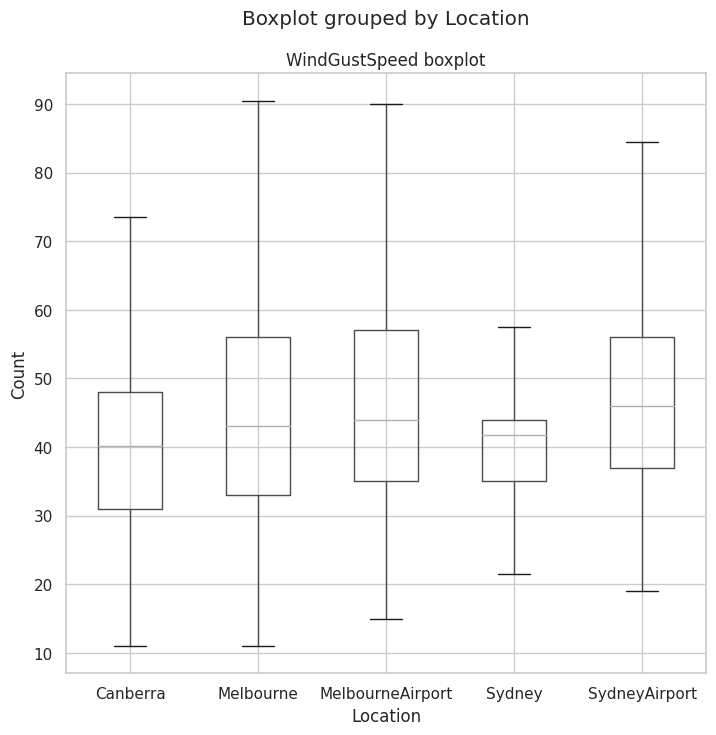

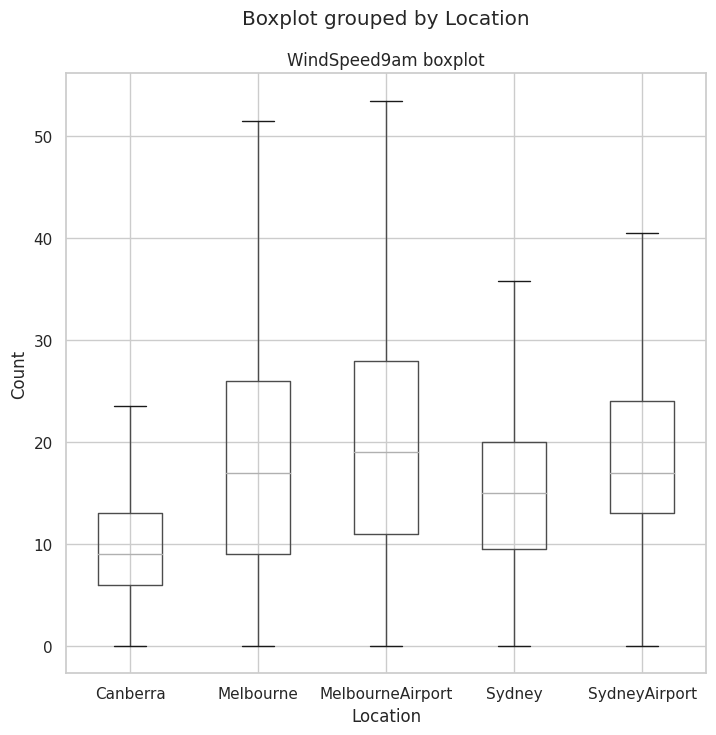

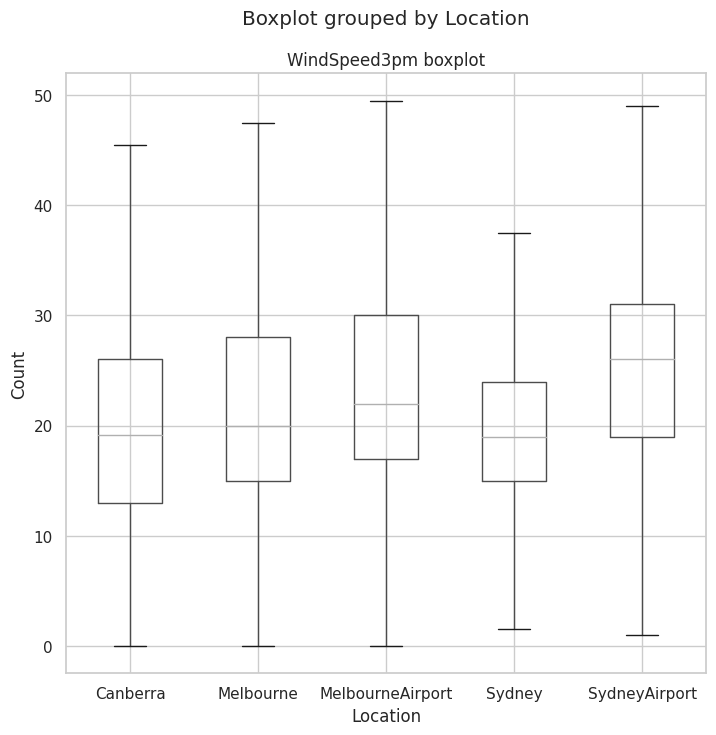

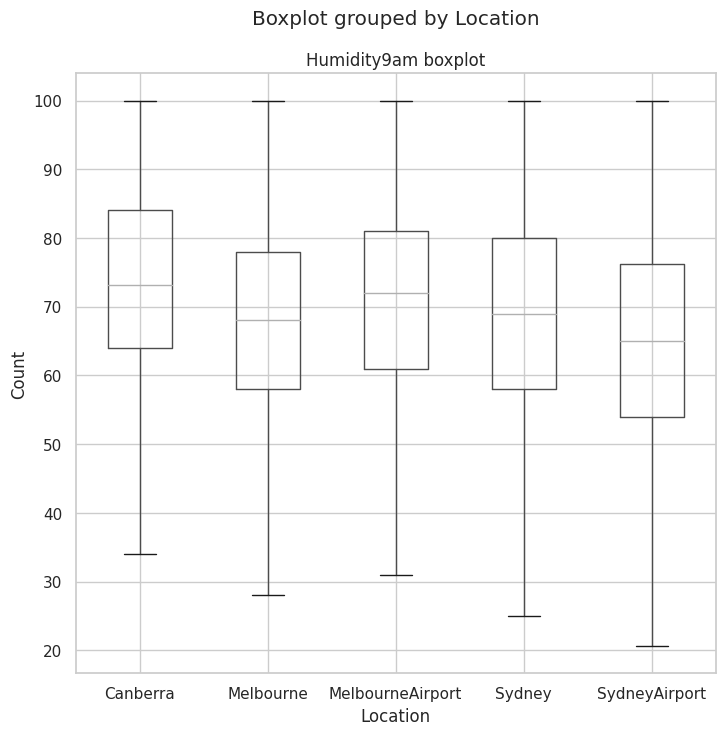

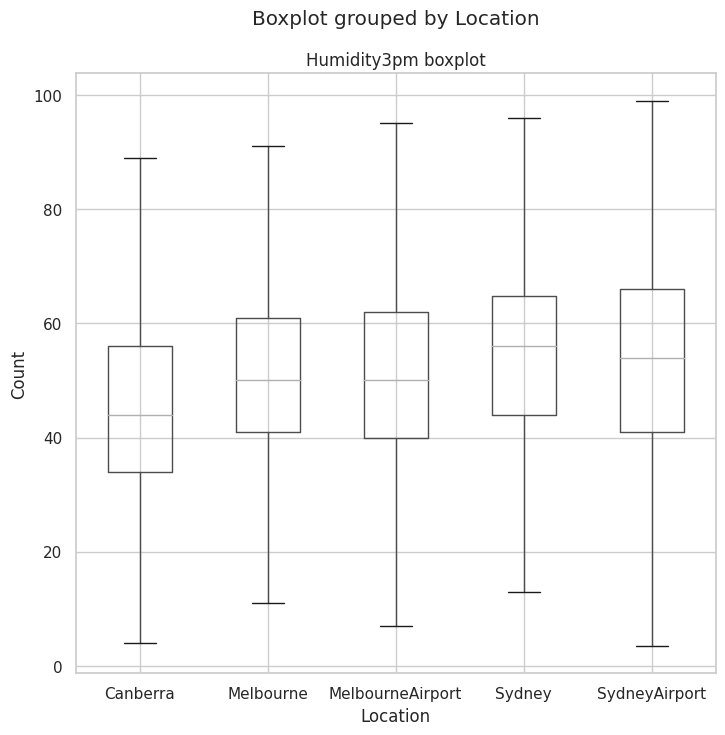

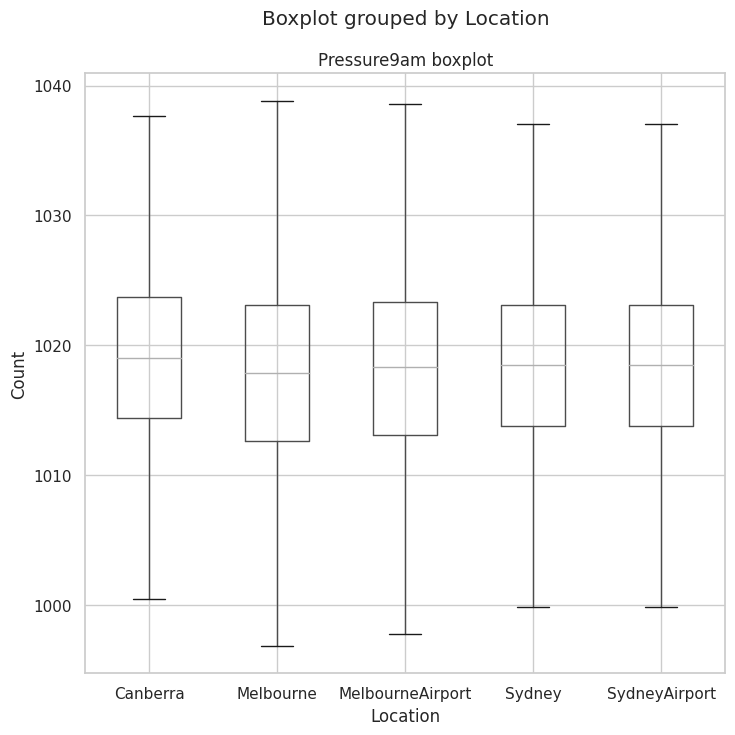

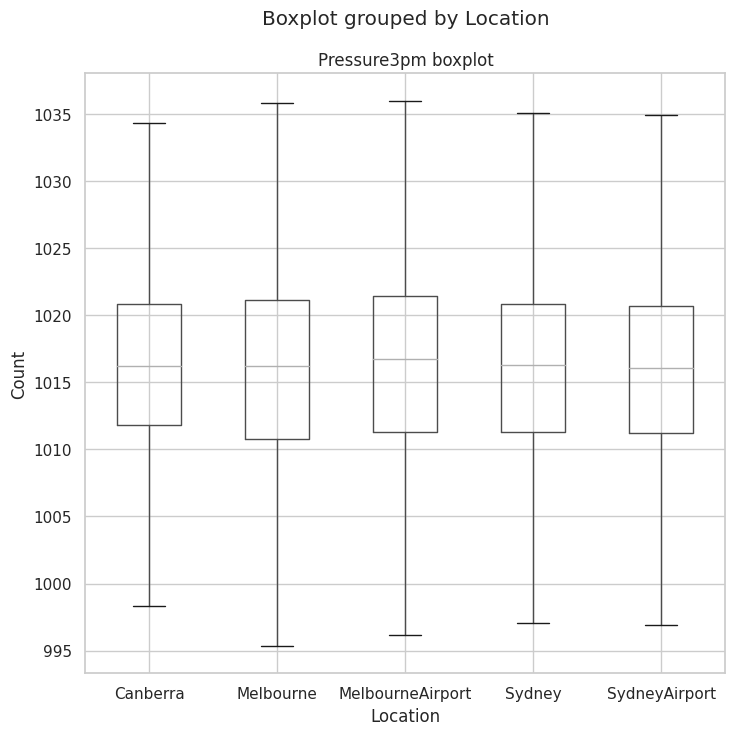

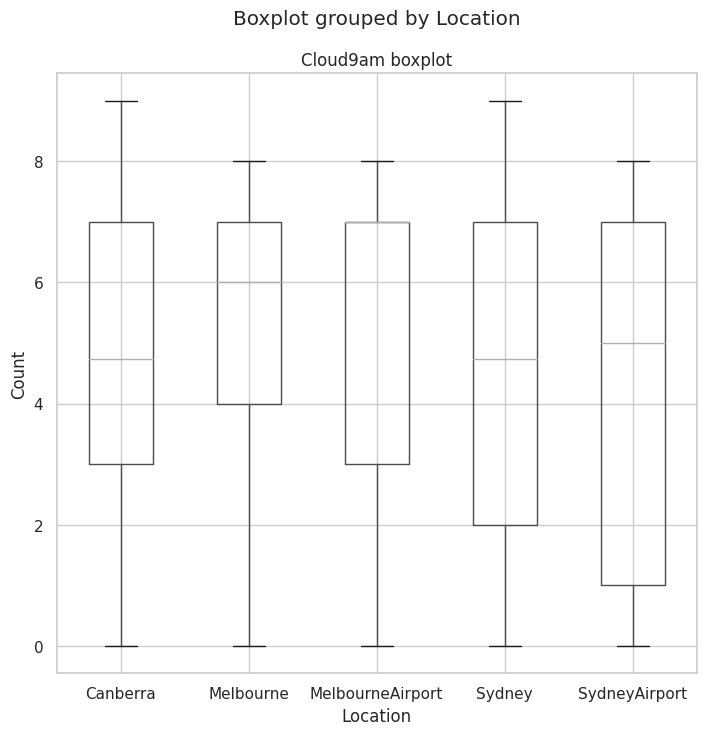

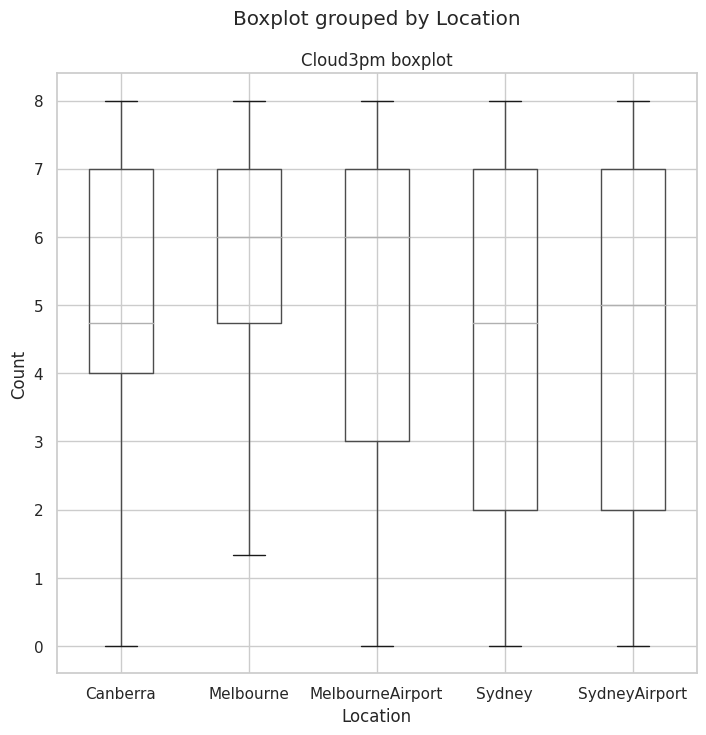

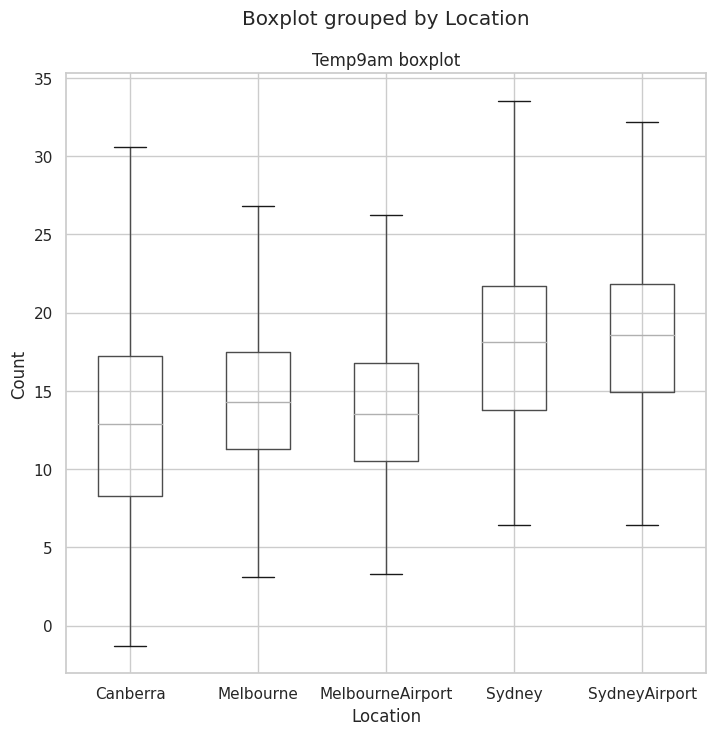

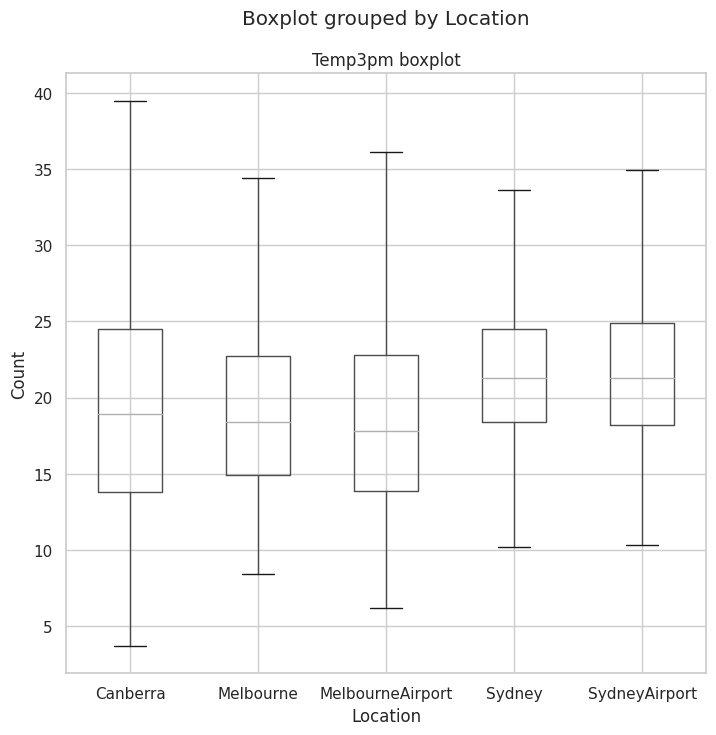

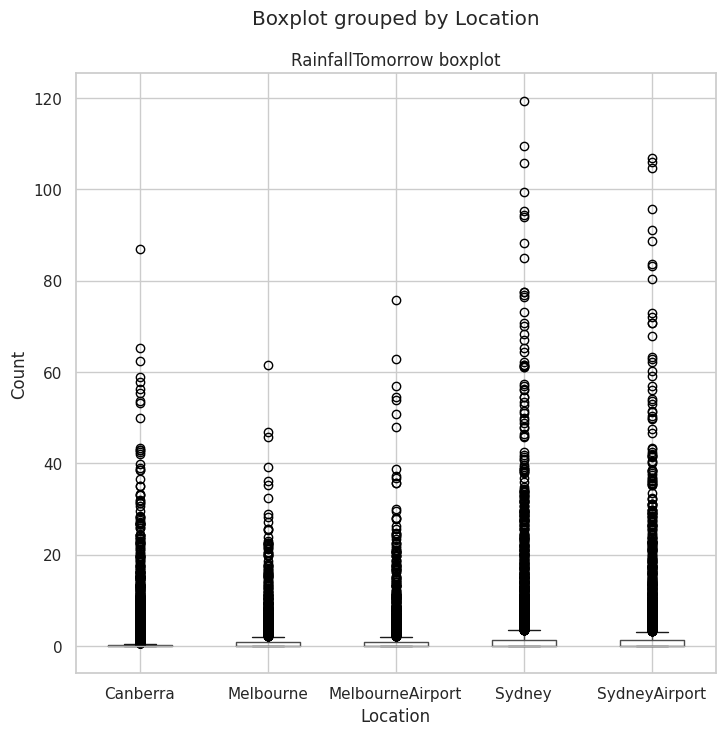

In [ ]:
# Visualizar boxplots
plt.figure(figsize=(8,8))
x_size = 10
y_size = 5
for n_col, column in enumerate(numerical):
  fig, axes = plt.subplots(figsize=(8,8))
  data_no_outliers.boxplot(column=column, by='Location', ax=axes)
  plt.ylabel('Count')
  plt.title(f'{column} boxplot')
  plt.show()

Luego, agregaremos más columnas: aquellas que representen una diferencia, como por ejemplo: TempDiff (diferencia entre la temperatura máxima y la mínima), PressureDiff (diferencia entre la presión a las 9am y a las 3pm), etc.

Nuevamente, este criterio lo tomamos con el fin de realizar comparaciones en las regresiones.

In [ ]:
# Crear columnas que aprecien la diferencia
data['TempDiff'] = data['MaxTemp'] - data['MinTemp']
data['PressureDiff'] = data['Pressure3pm'] - data['Pressure9am']
data['CloudDiff'] = data['Cloud3pm'] - data['Cloud9am']
data['WindSpeedDiff'] = data['WindSpeed3pm'] - data['WindSpeed9am']

data_no_outliers['TempDiff'] = data_no_outliers['MaxTemp'] - data_no_outliers['MinTemp']
data_no_outliers['PressureDiff'] = data_no_outliers['Pressure3pm'] - data_no_outliers['Pressure9am']
data_no_outliers['CloudDiff'] = data_no_outliers['Cloud3pm'] - data_no_outliers['Cloud9am']
data_no_outliers['WindSpeedDiff'] = data_no_outliers['WindSpeed3pm'] - data_no_outliers['WindSpeed9am']

Por último, agregamos las columnas correspondientes a la representación polar de las direcciones.

In [ ]:
for column in ['WindDir9am', 'WindDir3pm', 'WindGustDir','Date']:
  series_cos, series_sin = dir_to_circle(data['WindDir9am'])
  data[f'{column}_cos'] = series_cos
  data[f'{column}_sin'] = series_sin
  data_no_outliers[f'{column}_cos'] = series_cos
  data_no_outliers[f'{column}_sin'] = series_sin


# Estandarización
Para poder aplicar los modelos de regresión, debemos primero estandarizar las variables explicativas para que todas tengan el mismo desvío y una no pese mas que otra.

## Tipo de estandarización

La mayoría de las variables tienen distribución normal, es lógico aplicar z-score a estas.

Las variables que no tienen una distribución normal son las que explican las nubes, que son bimodales. Con el fin de mantener el desvío similar entre las variables, decidimos usar z-score en estas.

Sin embargo, hay algunas que tienen distribuciones distintas, aquellas que corresponden a las variables a explicar. Estas tienen distribuciones inversamente proporcional. Podemos decidir no estandarizarlas, aunque podríamos considerar hacerlo por motivos de recursos computacionales.

In [ ]:
# Inicializamos la instancia
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numerical_explicative])
scaled_data_no_outliers = scaler.fit_transform(data_no_outliers[numerical_explicative])

numerical_explicative + ['TempDiff', 'PressureDiff', 'CloudDiff', 'WindSpeedDiff',
       'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin',
       'WindGustDir_cos', 'WindGustDir_sin', 'Date_cos', 'Date_sin']

data[numerical_explicative] = scaled_data
data_no_outliers[numerical_explicative] = scaled_data_no_outliers

# Modelos de regresión lineal

En esta sección probamos tomando diferentes combinaciones de las variables que participan en el dataset, con el fin de quedarnos con aquel que mayor R^2 presente, es decir, que más explique la predicción de la variable 'RainfallTomorrow'.

Probaremos los modelos con los dos datasets definidos anteriormente: 'data' (sin tratar outliers) y 'df_no_outliers' (tratando outliers).


In [ ]:
# Eliminamos variables que no interesan.

data.drop(columns= ["Unnamed: 0", "Date"], inplace=True)

A continuación, codificaremos con get_dummies las variables categóricas: "Month", "WindGustDir", "RainToday", WindDir9am", "WindDir3pm" y "RainTomorrow" (que luego la quitaremos porque será nuestra variable a predecir)

In [ ]:
df_regresion = pd.get_dummies(data)
df_regresion.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow', 'TempDiff', 'PressureDiff',
       'CloudDiff', 'WindSpeedDiff', 'WindDir9am_cos', 'WindDir9am_sin',
       'WindDir3pm_cos', 'WindDir3pm_sin', 'WindGustDir_cos',
       'WindGustDir_sin', 'Date_cos', 'Date_sin', 'Location_Canberra',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N

Ahora, dentro del dataset contamos con distintas formas de representar algunas variables, como por ejemplo para la variable mes, tenemos doce variables dummy y dos variables que representan sus coordenadas polares.

Lo mismo sucede con "WindGustDir", "WindDir9am" y "WindDir3pm". Dichas variables están representadas de dos maneras en el dataset: con sus respectivas dummies y con sus respectivas coordenadas polares.

A continuación, entrenamos 6 modelos. Los tres primeros, utilizando el dataset con outliers. Los tres últimos, con el dataset 'data_no_outliers' en donde hemos tratado los atípicos.

Como se dijo anteriormente, probamos con dos datasets distintos con el fin de analizar cuánto impactan los outliers en los resultados de la regresión lineal.

### Modelo 1  (con outliers incluidos)

En este primer modelo, probaremos incluyendo todas las variables que participan en el dataset, a excepción de aquellas que intentamos predecir (RainfallTomorrow y RainTomorrow)

In [ ]:
X1 = df_regresion.drop(columns=['RainfallTomorrow', 'RainTomorrow_No', 'RainTomorrow_Yes'])  # Variables predictoras
y1 = df_regresion['RainfallTomorrow'] # Variable a predecir

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1.values.reshape(-1,1),test_size=0.2,random_state = 42)

model1 =  LinearRegression()

model1.fit(X_train1, y_train1)  # Entrenamos

y_pred1 = model1.predict(X_test1) # Predecimos

R2_1 = metrics.r2_score(y_test1, y_pred1)
print("R^2: ", round(R2_1,4))

R^2:  0.2318


Observamos que si incluimos absolutamente todas las variables, el R^2 nos da aproximadamente 0,232.

Sin embargo, este modelo posee variables predictoras redundantes, por lo explicado anteriormente. A continuación, probaremos eliminando las variables dummy de las que respectan a información sobre los vientos y los meses, quedándonos solo con sus coordenadas polares. ¿Mejorará nuestro R^2?

###Modelo 2 (con outliers incluidos)

En este segundo modelo, eliminamos de las variables predictoras todas las dummies referidas a los vientos y a los meses, quedándonos así con sus respectivas coordenadas polares. Decidimos tomar este criterio para el modelo con el fin de analizar si ésta es una buena forma de representar las variables.

In [ ]:
X2 = df_regresion.drop(columns=['RainfallTomorrow', 'RainTomorrow_No', 'RainTomorrow_Yes', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW',  'Month_Apr', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jan', 'Month_Jul', 'Month_Jun',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep'])  # Variables predictoras

y2 = df_regresion['RainfallTomorrow'] # Variable a predecir

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2.values.reshape(-1,1),test_size=0.2,random_state = 42)

model2 =  LinearRegression()

model2.fit(X_train2, y_train2)  # Entrenamos

y_pred2 = model2.predict(X_test2) # Predecimos

R2_2 = metrics.r2_score(y_test2, y_pred2)
print("R^2: ", round(R2_2,4))

R^2:  0.2321


El resultado del R^2 del modelo habiendo quitado las dummies mencionadas, fue de 0.232. Se observa un leve incremento respecto al modelo entrenado anteriormente. Esto nos indica que haber tranformado las variables del viento ("WindGustDir", "WindDir9am" y "WindDir3pm") y la variable de la fecha en sus respectivas coordenadas polares es una "buena" manera de representarlas.

Sin embargo, esta forma de representación de las variables es muy poco explicativa. En el siguiente modelo veremos si entrenándolo con las dummies mejoran o empeoran los resultados.

### Modelo 3 - Outliers incluidos

Como representar las variables categóricas referidas a los vientos y a los meses con sus coordenas polares no aporta explicatividad ya que es dificil interpretar y analizar sus valores, entrenamos un 3° modelo quitandólas y quedándonos con sus dummies.

Además, este modelo fue entrenado varias veces a modo de prueba. En cada prueba, quitamos y agregamos variables como por ejemplo aquellas que poseen valores a las 9am y a las 3pm, las diferencias (como CloudDiff, PressureDiff, entre otras), etc; con el fin de lograr la mayor explicatividad de la variable a predecir (RainfallTomorrow).

El mejor resultado arrojado luego de haber hecho varias pruebas fue el que muestra este 3° modelo.

In [ ]:
X3 = df_regresion.drop(columns=['RainfallTomorrow', 'RainTomorrow_No', 'RainTomorrow_Yes', 'Date_cos', 'Date_sin', 'WindDir9am_cos',
                                'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin', 'WindGustDir_cos', 'WindGustDir_sin', 'Temp9am',
                                'Temp3pm', 'TempDiff', 'PressureDiff', 'CloudDiff', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW'])  # Variables predictoras

y3 = df_regresion['RainfallTomorrow'] # Variable a predecir

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3.values.reshape(-1,1),test_size=0.2,random_state = 42)

model3 =  LinearRegression()

model3.fit(X_train3, y_train3)  # Entrenamos

y_pred3 = model3.predict(X_test3) # Predecimos

R2_3 = metrics.r2_score(y_test3, y_pred3)
print("R^2: ", round(R2_3,4))

R^2:  0.2344


In [ ]:
print(X3.columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'WindSpeedDiff', 'Location_Canberra', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'RainToday_No', 'RainToday_Yes',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan',
       'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep'],
      dtype='object')


Este modelo, que fue entrenado varias veces con más o menos variables, arroja un resultado de R^2 de 0,2344 (valor más alto hasta el momento).

Concluimos que para el dataset sin tratar outliers, la mejor predicción de RainfallTomorrow se da cuando las variables predictoras son: 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'WindSpeedDiff', 'Location_Canberra', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'RainToday_No', 'RainToday_Yes',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jan',
       'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep'


A modo de observación, la mayor disminución de R^2 se dio cuando quitamos las variables referidas a la humedad. Esto nos da la idea de que dichas variables son necesarias para hacer una buena predicción de lluvia.

### Modelo 4 (sin outliers incluidos)

En los próximos dos modelos, utilizaremos el dataset en el cual tratamos los outliers: 'data_no_outliers'. Aquí, el objetivo será ver si los resultados son mejores que en los modelos anteriores, donde no tratamos los outliers.


In [ ]:
# quitamos columnas de más

data_no_outliers.drop(columns= ["Unnamed: 0", "Date"], inplace=True)

In [ ]:
# codificamos dummies

dummies_no_out = pd.get_dummies(data_no_outliers)
dummies_no_out.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow', 'TempDiff', 'PressureDiff',
       'CloudDiff', 'WindSpeedDiff', 'WindDir9am_cos', 'WindDir9am_sin',
       'WindDir3pm_cos', 'WindDir3pm_sin', 'WindGustDir_cos',
       'WindGustDir_sin', 'Date_cos', 'Date_sin', 'Location_Canberra',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N

Haremos lo mismo que en el primer modelo: tomar todas las variables, aunque algunas sean redundantes.

In [ ]:
X4 = dummies_no_out.drop(columns=['RainfallTomorrow', 'RainTomorrow_No', 'RainTomorrow_Yes'])  # Variables predictoras
y4 = dummies_no_out['RainfallTomorrow'] # Variable a predecir

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4,y4.values.reshape(-1,1),test_size=0.2,random_state = 42)

model4 =  LinearRegression()

model4.fit(X_train4, y_train4)  # Entrenamos

y_pred4 = model4.predict(X_test4) # Predecimos

R2_4 = metrics.r2_score(y_test4, y_pred4)
print("R^2: ", round(R2_4,4))

R^2:  0.223


El R^2 para este primer modelo sin outliers es de aproximadamente 0.22. Por el momento, es el más bajo.

### Modelo 5 - sin outliers incluidos

Finalmente, entrenaremos un último modelo de regresión lineal con las mismas variables predictoras que en el caso del modelo 3, que fue el que mejor R^2 nos dio.

In [ ]:
X5 = dummies_no_out.drop(columns=['RainfallTomorrow', 'RainTomorrow_No', 'RainTomorrow_Yes', 'Date_cos', 'Date_sin', 'WindDir9am_cos',
                                'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin', 'WindGustDir_cos', 'WindGustDir_sin', 'Temp9am',
                                'Temp3pm', 'TempDiff', 'PressureDiff', 'CloudDiff', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW'])  # Variables predictoras

y5 = dummies_no_out['RainfallTomorrow'] # Variable a predecir

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5,y5.values.reshape(-1,1),test_size=0.2,random_state = 42)

model5 =  LinearRegression()

model5.fit(X_train5, y_train5)  # Entrenamos

y_pred5 = model5.predict(X_test5) # Predecimos

R2_5 = metrics.r2_score(y_test5, y_pred5)
print("R^2: ", round(R2_5,4))

R^2:  0.2254


Ambos modelos sin outliers en el dataset nos han arrojado valores de R^2 menores que el modelo 3. Esto nos indica que un modelo de regresión lineal, para este dataset en particular, puede explicar mejor las predicciones sin que tratemos los valores atípicos.

A continuación, guardaremos la información del modelo 3 para luego analizar resultados y aplicar otros tipos de modelos, como por ejemplo de regularización.

In [ ]:
xtrain_mod3 = X_train3
xtest_mod3 = X_test3
ytrain_mod3 = y_train3
ytest_mod3 = y_test3
ypred_mod3 = y_pred3

### Analizando las métricas del modelo 3

Como el modelo 3 fue el que mejor R^2 nos otorgó, haremos un breve análisis del mismo.

En el siguiente gráfico se observan los valores que tomaron los coeficientes de las variables predictoras.

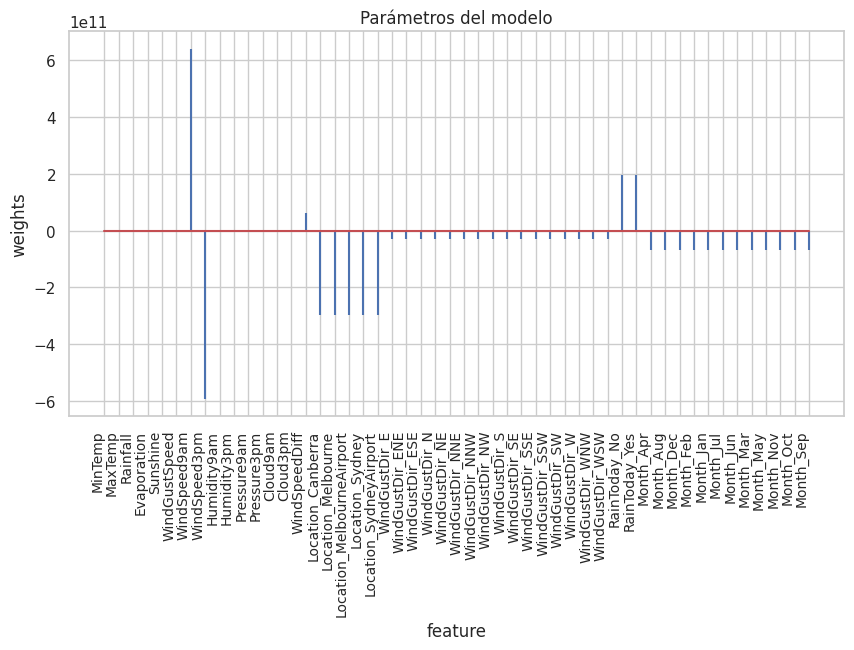

In [ ]:
df_coeficientes = pd.DataFrame({'predictor': xtrain_mod3.columns, 'coef': model3.coef_.flatten()})

fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.show()

In [ ]:
rmse_mod3 = mean_squared_error(ytest_mod3, ypred_mod3, squared = False)

print(f"El error (rmse) de test es: {round(rmse_mod3,4)}")

El error (rmse) de test es: 7.2446


In [ ]:
R2_mod3 = metrics.r2_score(ytest_mod3, ypred_mod3)
print(f"El R^2 para el modelo de regresión lineal 3 es: {round(R2_mod3,4)}")

El R^2 para el modelo de regresión lineal 3 es: 0.2344


Observamos el gráfico de residuos del modelo.

<ipython-input-88-f11197c24d45>:5: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(ytest_mod3,100*(ytest_mod3-ypred_mod3)/ytest_mod3)


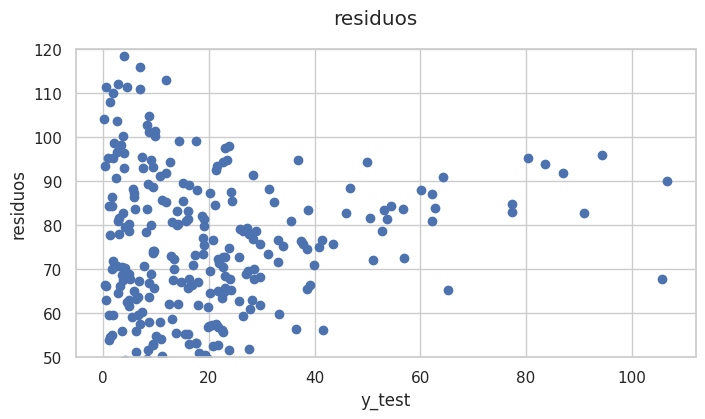

In [ ]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(ytest_mod3,100*(ytest_mod3-ypred_mod3)/ytest_mod3)
plt.ylim(50,120)
plt.show()

Esta métrica tiene muchos problemas con nuestro dataset debido al hecho de que la mayoría de nuestros datos están concentrados en días de poca lluvia, por lo que un error percentual no es interpretado fácilmente.

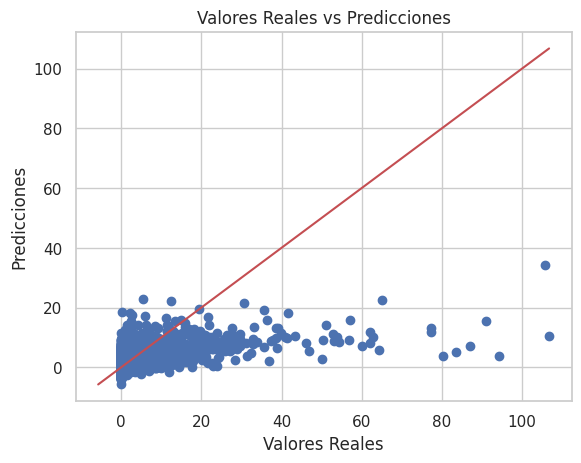

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(ytest_mod3, ypred_mod3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs Predicciones')

diagonal = np.linspace(min(ytest_mod3.min(), ypred_mod3.min()), max(ytest_mod3.max(), ypred_mod3.max()))
plt.plot(diagonal, diagonal, '-r')
plt.show()

Debido al hecho de que los datos no están balanceados, el modelo se sobreajusta respecto a los días con poca lluvia, por esto se encuentran muchos puntos por debajo de la identidad.



# Gradiente Descendiente
Probemos utilizar las funciones definidas en clase

In [ ]:
def gradient_descent(X_train, y_train, X_test, y_test, learning_rate=0.01, num_iterations=1000, random_seed=42):
    """
    Perform gradient descent to fit a linear regression model and plot learning and testing errors.

    Parameters:
    - X_train: Numpy array of shape (m_train, n) for training features.
    - y_train: Numpy array of shape (m_train,) for training target variable.
    - X_test: Numpy array of shape (m_test, n) for testing features.
    - y_test: Numpy array of shape (m_test,) for testing target variable.
    - learning_rate: The learning rate for gradient descent.
    - num_iterations: The number of iterations for gradient descent.

    Returns:
    - theta: Numpy array of shape (n,) representing the learned coefficients.
    """
    # Seteamos random seed
    np.random.seed(42)
    m_train, n = X_train.shape
    m_test, _ = X_test.shape
    #theta = np.zeros(n)  # Initialize coefficients to zeros
    theta = np.random.rand(n) # Coeficientes aleatorios

    train_errors = []
    test_errors = []

    for epoch in range(num_iterations):
        # Calculate the predicted values for training and testing sets
        y_train_pred = X_train.dot(theta)
        y_test_pred = X_test.dot(theta)

        # Calculate the training and testing errors (Mean Squared Error)
        train_error = np.mean((y_train_pred - y_train) ** 2)
        test_error = np.mean((y_test_pred - y_test) ** 2)

        train_errors.append(train_error)
        test_errors.append(test_error)

        # Calculate the gradient for training set
        gradient = (1 / m_train) * X_train.T.dot(y_train_pred - y_train)

        # Update the coefficients using gradient descent
        theta -= learning_rate * gradient

    # Plot learning and testing errors
    plt.figure()
    plt.plot(range(num_iterations), train_errors, label='Training Error')
    plt.plot(range(num_iterations), test_errors, label='Testing Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

    return theta


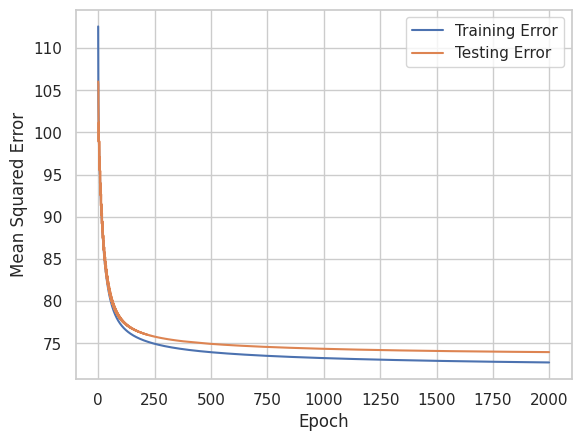

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3)
theta = gradient_descent(X_train3, y_train3, X_test3, y_test3, learning_rate=0.015, num_iterations=2000)



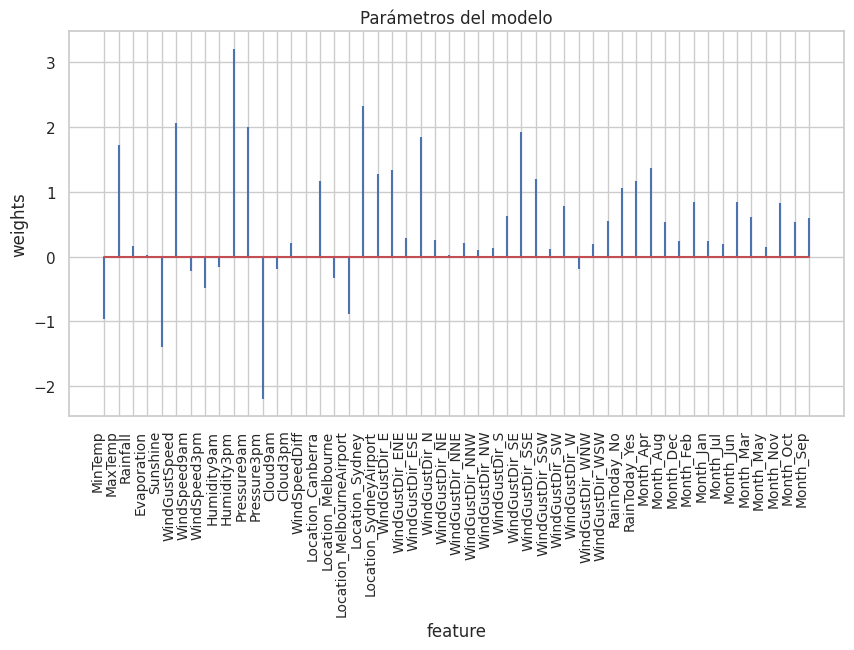

R2 error: 0.2690791017614389


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(theta.index, theta.values, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo')
plt.show()


# Calculamos el R2

y_pred3 = X_train3.apply(lambda x: np.dot(theta.values,x), axis=1)
y_pred3.shape
R2 = metrics.r2_score(y_train3, y_pred3)
print(f'R2 error: {R2}')

Podemos ver que el R2 ronda entre 0.26 y 0.28. En el gráfico podemos observar cuáles son las variables que tienen más peso y cuáles no.

# Regularizaciones: Ridge, Lasso y Elastic Net

Basándonos en el modelo de regresión lineal 3, que fue el que mejores resultados nos otorgó, realizaremos regularización Ridge.

In [ ]:
modelo_ridge = RidgeCV(alphas = np.logspace(-10, 10, 200),
                           fit_intercept   = True,
                           store_cv_values = True)

_ = modelo_ridge.fit(xtrain_mod3, ytrain_mod3)

A continuación, vemos como fueron variando los parámetros del modelo.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.76881e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.28349e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.38049e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.08396e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


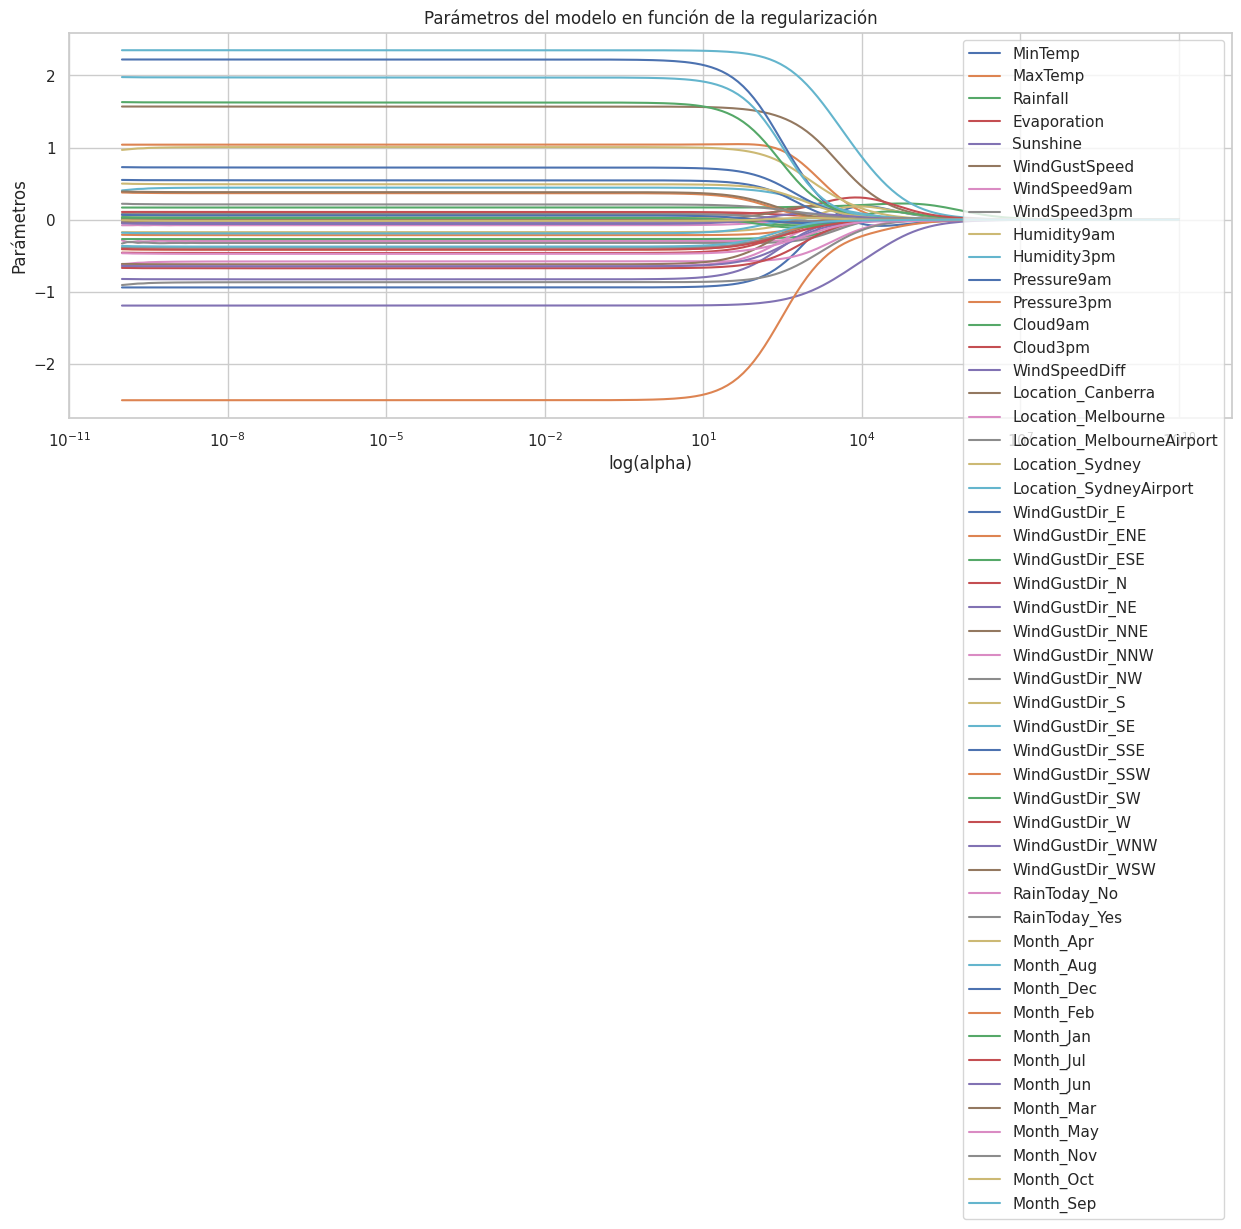

In [ ]:
alphas = modelo_ridge.alphas
coefs = []

for alpha in alphas:
    modelo_aux =  Ridge(alpha=alpha)
    modelo_aux.fit(xtrain_mod3, ytrain_mod3)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=xtrain_mod3.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

En el siguiente gráfico se muestra cómo fue evolucionando el error de validación en función del alpha.

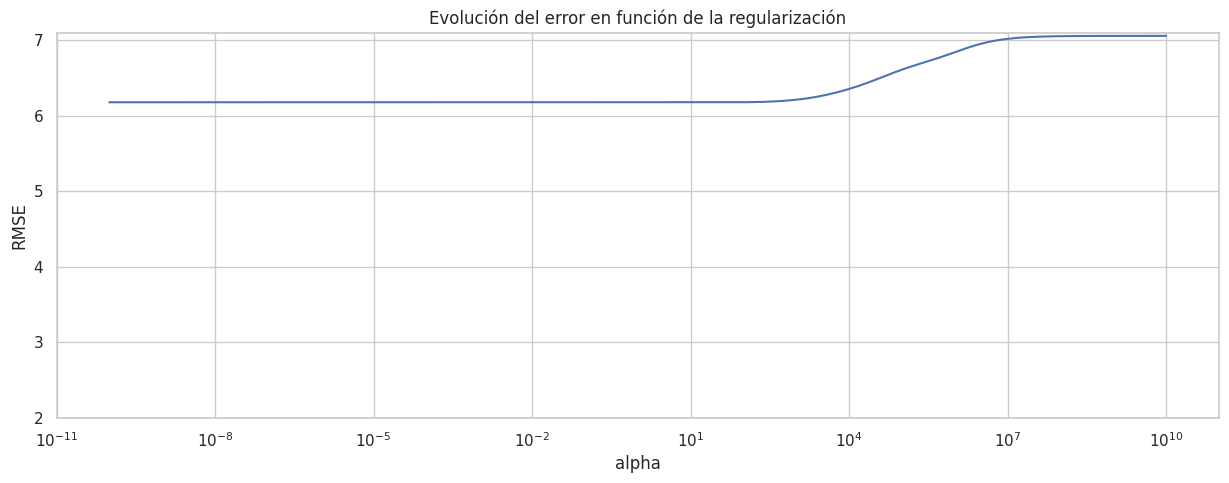

In [ ]:
mse_cv = modelo_ridge.cv_values_.reshape((-1, 200)).mean(axis=0)

# Aplicamos la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Identificamos el mejor
min_rmse     = np.min(rmse_cv)
optimo       = modelo_ridge.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(modelo_ridge.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [ ]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado en Ridge: {round(modelo_ridge.alpha_,4)}")

Mejor valor de alpha encontrado en Ridge: 36.1234


Vemos que el mejor alpha que encontró el modelo es 36.12 aproximadamente.

Finalmente, conoceremos el R^2 y el rmse luego de aplicar la regularización Ridge.

In [ ]:
from sklearn.metrics import r2_score

y_pred_ridge = modelo_ridge.predict(xtest_mod3)
R2_ridge = r2_score(ytest_mod3, y_pred_ridge)

print("R^2 luego de aplicar Ridge:", round(R2_ridge,4))

R^2 luego de aplicar Ridge: 0.2339


In [ ]:
rmse_ridge = mean_squared_error(ytest_mod3,
                y_pred_ridge,
                squared = False
             )

print(f"El error (rmse) de test para Ridge es: {round(rmse_ridge,4)}")

El error (rmse) de test para Ridge es: 7.247


Observamos que el R^2 no ha mejorado respecto a los resultados de la regresión lineal en el modelo 3. Da un resultado muy similar.

### Regularización Lasso

Entrenaremos el modelo aplicando Lasso y luego visualizaremos cómo variaron los coeficientes del modelo en función de la regularización.

In [ ]:
modelo_lasso = LassoCV(alphas=np.logspace(-2, 2, 200), cv=10)
_ = modelo_lasso.fit(xtrain_mod3, ytrain_mod3.ravel())

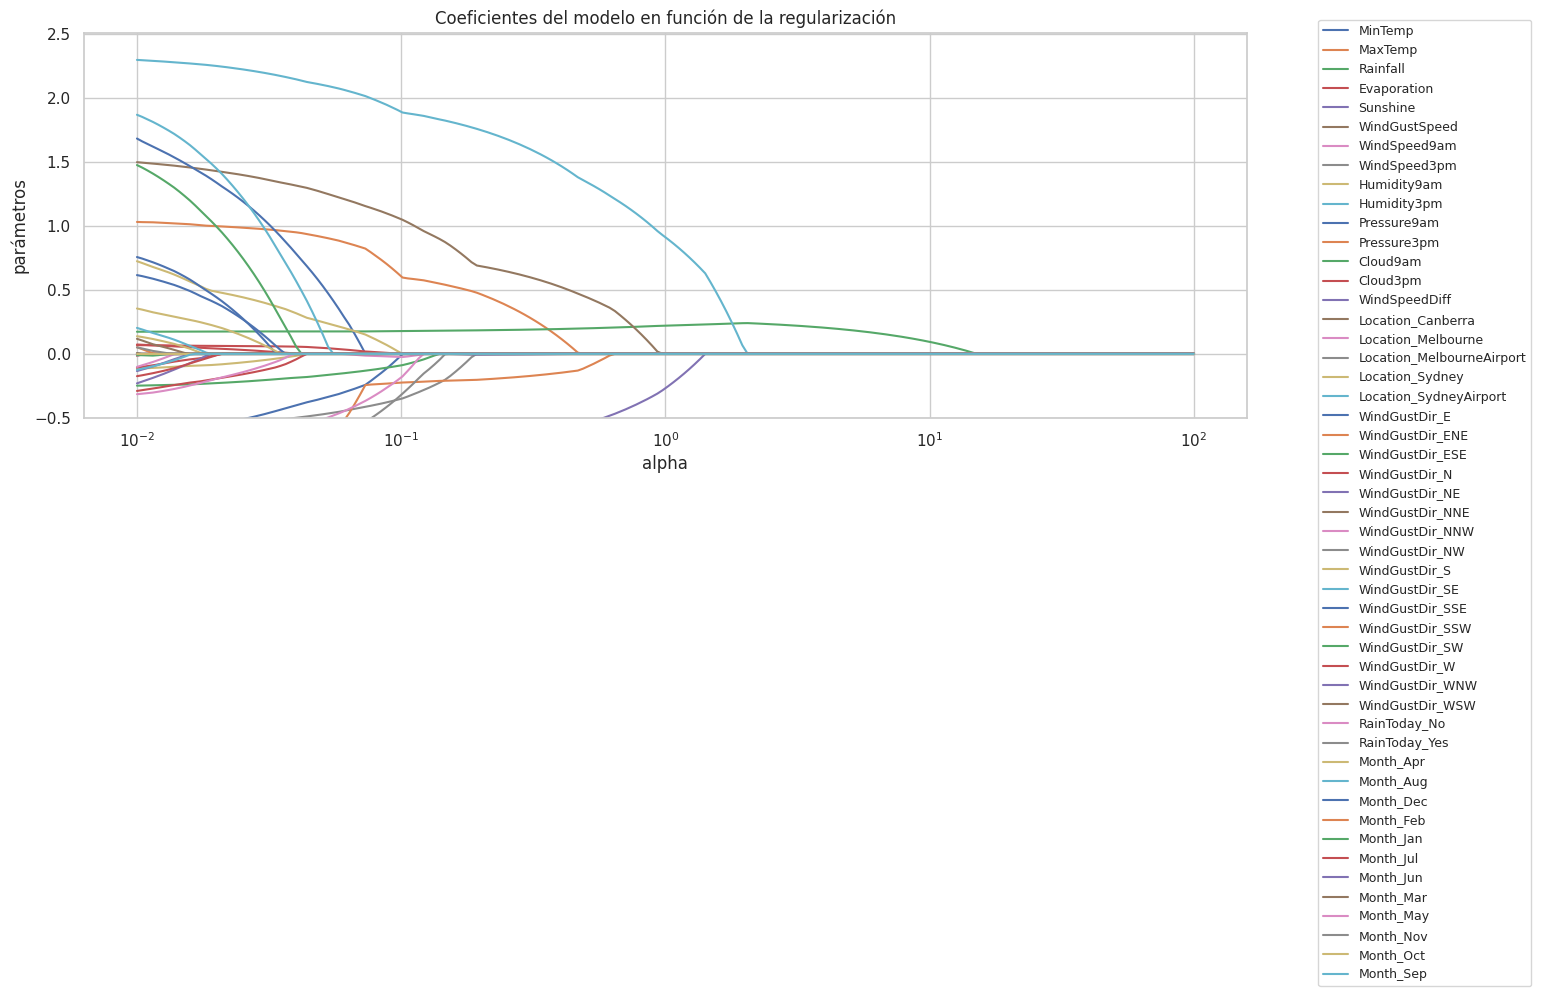

In [ ]:
alphas = modelo_lasso.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(xtrain_mod3, ytrain_mod3)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=xtest_mod3.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')

ax.legend()
# Ajustar la leyenda
legend = ax.legend(prop={'size': 9}, loc='upper right', bbox_to_anchor=(1.25, 1.05))
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Luego, hacemos predicciones y calculamos el error rmse y el R^2.

In [ ]:
y_pred_lasso = modelo_lasso.predict(xtest_mod3)

rmse_lasso = mean_squared_error(ytest_mod3,y_pred_lasso,squared = False)
print(f"El error (rmse) de test es: {round(rmse_lasso,4)}")

R2_lasso = metrics.r2_score(ytest_mod3, y_pred_lasso)
print(f"El R^2 para Lasso es: {round(R2_lasso,4)}")

El error (rmse) de test es: 7.2533
El R^2 para Lasso es: 0.2326


Observamos que Lasso tampoco ha podido mejorar el resultado del R^2 respecto al del modelo 2 de regresión lineal, arrojando un R^2 aún menor que Ridge.

A continuación, un gráfico de cómo quedaron los coeficientes.

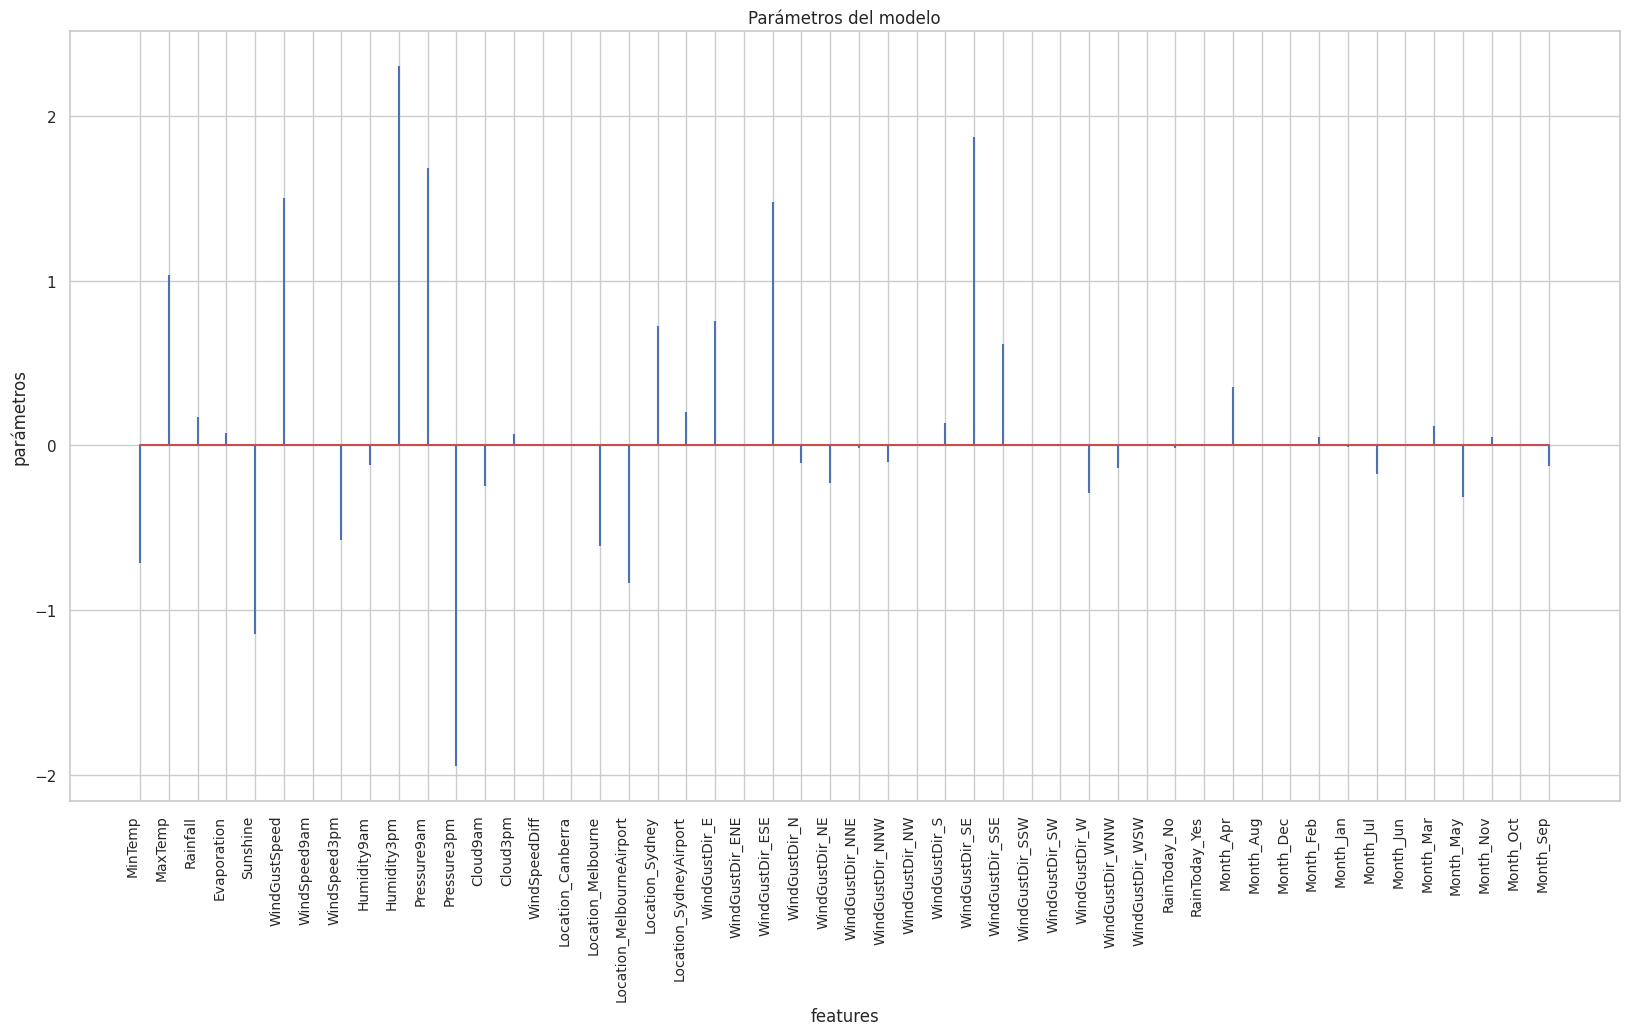

In [ ]:
df_coeficientes = pd.DataFrame(
                        {'predictor': xtrain_mod3.columns,
                         'coef': modelo_lasso.coef_.flatten()}
                  )

df_coeficientes[df_coeficientes.coef != 0]

fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

## Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNetCV

In [ ]:
modelo_elastic = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas = np.logspace(-1, 1, 200),
                              cv = 10)

_ = modelo_elastic.fit(xtrain_mod3, ytrain_mod3)

In [ ]:
print(f"Mejor valor de alpha encontrado: {modelo_elastic.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo_elastic.l1_ratio_}")

Mejor valor de alpha encontrado: 0.1
Mejor valor de l1_ratio encontrado: 0.1


In [ ]:
# Parámetros del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': xtrain_mod3.columns,
                         'coef': modelo_elastic.coef_.flatten()}
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

Luego, haremos predicciones.

In [ ]:
y_pred_elastic = modelo_elastic.predict(xtest_mod3)

rmse_elastic = mean_squared_error(ytest_mod3,y_pred_elastic, squared = False)
print("")
print(f"El error (rmse) de test es: {round(rmse_elastic,4)}")

R2_elastic = metrics.r2_score(ytest_mod3, y_pred_elastic)
print(f"El R^2 de elastic net es: {round(R2_elastic,4)}")

# Comparación Regresión Lineal - Ridge - Lasso - Elastic Net

A continuación, compararemos el rmse y el R^2 luego de haber entrenado el modelo 3 con regresión lineal, ridge, lasso y elastic net.

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_mod3, rmse_ridge, rmse_lasso, rmse_elastic],
                    'R2': [R2_mod3, R2_ridge, R2_lasso, R2_elastic]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

Las diferencia entre los cuatro valores es mínima, casi no se diferencia a simple vista.

In [ ]:
for index, row in df_comparacion.iterrows():
    print(f"El valor de RMSE de {row['modelo']} es {row['test rmse']:.4f}")

print("")
for index, row in df_comparacion.iterrows():
    print(f"El valor de R^2 de {row['modelo']} es {row['R2']:.4f}")

El valor de RMSE de LinearRegression es 7.2446
El valor de RMSE de Ridge es 7.2470
El valor de RMSE de Lasso es 7.2533
El valor de RMSE de Elastic-net es 7.3222

El valor de R^2 de LinearRegression es 0.2344
El valor de R^2 de Ridge es 0.2339
El valor de R^2 de Lasso es 0.2326
El valor de R^2 de Elastic-net es 0.2180


Como se mencionó, la diferencia es mínima. El modelo que mayor rmse arrojó es Elastic Net, mientras que el que menos rmse obtuvo es el de la regresión lineal.

En cuanto a los R^2, el mejor valor fue obtenido por la regresión lineal, y el peor por Elastic Net.

Sin embargo, la diferencia es muy pequeña entre todos los valores (casi insignificante).

# Balanceo

Al intentar predecir las variables que nos interesan, 'RainfallTomorrow', y "RainTomorrow", nos encontramos con un problema: la mayoría de los días en el conjunto de datos no presentan lluvia ('RainTomorrow' = 'No').

Esta desproporción puede afectar tanto a los modelos de regresión como a los de clasificación, ya que el modelo puede tener dificultades para aprender de los datos debido a la falta de ejemplos positivos ('RainTomorrow' = 'Yes').

Para abordar este problema de desequilibrio de clases, decidimos aplicar una técnica de oversampling a los días en que no llueve. Esto implica duplicar o generar datos sintéticos de las instancias de 'No llueve' para igualar la proporción entre las dos clases.

Como esta estrategia tiene como objetivo mejorar la capacidad del modelo para aprender de los ejemplos negativos, primero analizaremos si mejora el rendimiento del modelo número 3 creado anteriormente.

In [ ]:
# Calculamos el número de días lluviosos y no lluviosos
rainy_data = data[data['RainTomorrow'] == 'Yes']
non_rain_data = data[data['RainTomorrow'] == 'No']

# Número de veces para aplicar oversampling
oversample_factor = len(non_rain_data) // len(rainy_data)

oversampled_rainy_data = pd.concat([rainy_data] * oversample_factor, axis=0)

# Concatenamos los dataframes: días lluviosos con oversampling y días no lluviosos del df original
oversampled_data = pd.concat([non_rain_data, oversampled_rainy_data], axis=0)

Como se observa, una vez que hemos aplicado oversampling, contamos con 10329 registros donde 'RainTomorrow' vale 'Yes' y 11593 registros donde 'RainTomorrow' vale 'No'.

In [ ]:
rainy_count = oversampled_data['RainTomorrow'].value_counts()['Yes']
non_rain_count = oversampled_data['RainTomorrow'].value_counts()['No']

print(f'Número de registros con RainTomorrow=Yes: {rainy_count}')
print(f'Número de registros con RainTomorrow=No: {non_rain_count}')

A continuación, graficamos las variables categóricas para ver cómo varió el gráfico de 'RainTomorrow'

In [ ]:
# Gráficos de frecuencias de variables categóricas

fig, axes = plt.subplots(3, 3, figsize=(25, 15))
axes = axes.flatten()
for i, var in enumerate(categorical):
    sns.countplot(data=oversampled_data, x=var, palette="Set3", ax=axes[i])
    axes[i].set_title(f'{var} Distribution')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

Como mencionamos anteriormente, nos interesa volver a entrenar el modelo n°3 pero ésta vez sobre el nuevo dataframe con el fin de corroborar si, al haberlo balanceado, otorga mejores resultados.

In [ ]:
# Volvemos a entrenar el modelo 3, pero con el dataframe balanceado.

df_regresion = pd.get_dummies(oversampled_data)

X3 = df_regresion.drop(columns=['RainfallTomorrow', 'RainTomorrow_No', 'RainTomorrow_Yes', 'Date_cos', 'Date_sin', 'WindDir9am_cos',
                                'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin', 'WindGustDir_cos', 'WindGustDir_sin', 'Temp9am',
                                'Temp3pm', 'TempDiff', 'PressureDiff', 'CloudDiff', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW'])  # Variables predictoras

y3 = df_regresion['RainfallTomorrow'] # Variable a predecir

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3.values.reshape(-1,1),test_size=0.2,random_state = 42)

model3 =  LinearRegression()

model3.fit(X_train3, y_train3)  # Entrenamos

y_pred3 = model3.predict(X_test3) # Predecimos

R2_3 = metrics.r2_score(y_test3, y_pred3)
print("R^2: ", round(R2_3,4))

Se observa un aumento significativo en el coeficiente de determinación R^2 (anteriormente en 0.2344, ahora en 0.3023) después de balancear los datos. Este incremento sugiere que el modelo ha mejorado su capacidad para predecir la variable 'RainfallTomorrow'. El balanceo de datos ha permitido al modelo realizar predicciones más precisas y coherentes.

Aún así, consideramos que no llega a ser un R^2 aceptable.

Graficamos a continuación, los valores reales vs predicciones.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(y_test3, y_pred3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs Predicciones')

diagonal = np.linspace(min(y_test3.min(), y_pred3.min()), max(y_test3.max(), y_pred3.max()))
plt.plot(diagonal, diagonal, '-r')
plt.show()

# Regresión logística

Una vez balanceado el dataset, el propósito de esta sección es predecir la variable categórica 'RainTomorrow' mediante un modelo de regresión logística y analizar sus métricas.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [ ]:
df_regresion = pd.get_dummies(oversampled_data)

X_log = df_regresion.drop(columns=['RainfallTomorrow', 'RainTomorrow_No', 'RainTomorrow_Yes', 'Date_cos', 'Date_sin', 'WindDir9am_cos',
                                'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin', 'WindGustDir_cos', 'WindGustDir_sin', 'Temp9am',
                                'Temp3pm', 'TempDiff', 'PressureDiff', 'CloudDiff', 'WindDir9am_E', 'WindDir9am_ENE',
                                'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
                                'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
                                'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
                                'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
                                'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
                                'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
                                'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
                                'WindDir3pm_WNW', 'WindDir3pm_WSW'])  # Variables predictoras

y_log = df_regresion['RainTomorrow_Yes'] # Variable a predecir

X_trainlog, X_testlog, y_trainlog, y_testlog = train_test_split(X_log,y_log.values.reshape(-1,1),test_size=0.2,random_state = 42)

# Entrenamos el modelo de regresión logística
model_log = LogisticRegression(max_iter=1000)

model_log.fit(X_trainlog, y_trainlog)

y_predlog = model_log.predict(X_testlog)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Matriz de confusión
Aquí podemos visualizar la cantidad de valores predecidos versus los reales.

En el caso de un modelo de clasificación binaria, podemos analizar métricas tales como accuracy, precisión, recall, F1 score


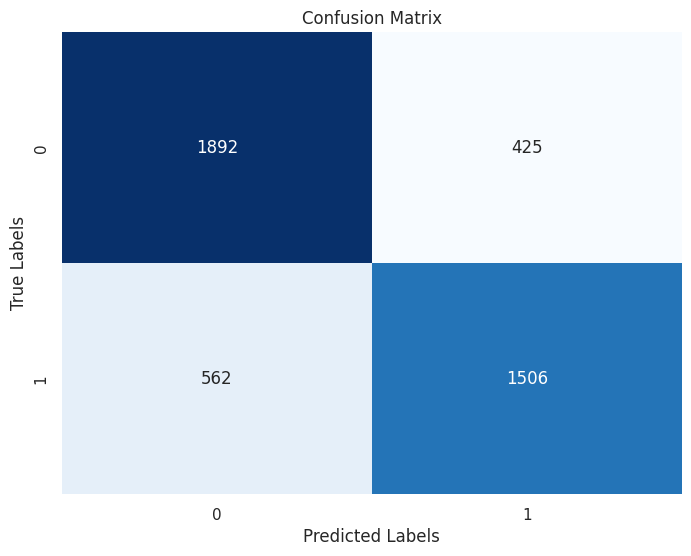

In [ ]:
# matriz de confusión
conf_matrix = confusion_matrix(y_testlog, y_predlog)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = accuracy_score(y_testlog, y_predlog)
precision = precision_score(y_testlog, y_predlog, average='weighted')
recall = recall_score(y_testlog, y_predlog, average='weighted')
f1 = f1_score(y_testlog, y_predlog, average='weighted')
roc_auc = roc_auc_score(y_testlog, y_predlog)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.7749144811858609
Precision: 0.7751931875804607
Recall: 0.7749144811858609
F1 Score: 0.7742906104620529
ROC-AUC: 0.7724065001014284


Como podemos observar, las métricas han dado valores similares alrededor de 0.77. Son razonables según la naturaleza del problema, en el sentido de que un falso positivo o negativo no tendrá grandes repercusiones (nadie va a morir en el caso de una mala predicción de la lluvia). Si estuviesemos estudiando otros problemas, tal vez sea necesario ser más exigentes de las métricas.


# Curva ROC
A continuación vemos la curva ROC

En una curva ROC, cada punto representa un modelo de clasificación binaria, mientras que los ejes x e y representan los falsos positivos y los verdaderos positivos respectivamente.

Si la curva se encuentra por debajo de la identidad, hay más falsos positivos que verdaderos, lo que implica un mal modelo. Si la curva se encuentra por encima, lo contrario.

Un punto ideal es la esquina superior izquierda que implica que no hay falsos positivos.

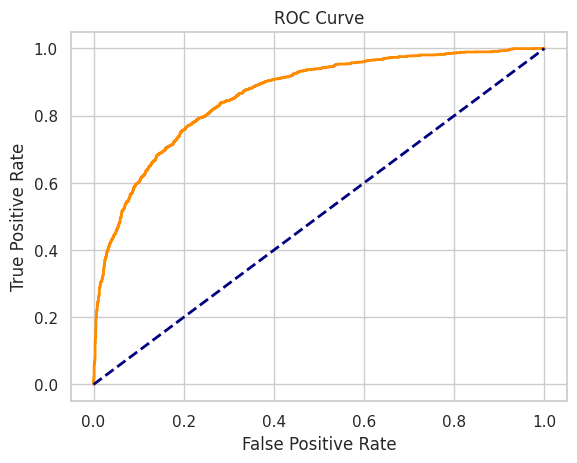

In [ ]:
# curva ROC (Receiver Operating Characteristic)
fpr, tpr, _ = roc_curve(y_testlog, model_log.predict_proba(X_testlog)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Conclusiones
Como podemos observar, la curva de los modelos de regresión logística se encuentra por encima de la identidad. Junto con el análisis de métricas, podemos concluir que nuestro modelo de regresión logística predice considerablemente bien.